# Torch tests 

In [7]:
import colorsys, contextlib, datetime, os, pathlib, platform, pprint, sys
import gtda
import ipywidgets as widgets
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL
import PIL.Image as Image
import plotly as py
import plotly.graph_objs as go
import plotly.io as pio
import pomegranate as pg
import seaborn as sns
import sdv
import sklearn
import torch
import torch.nn as nn
import torch.nn.functional as F
import yellowbrick as yb

fastai_gpu_conflict = True
if(fastai_gpu_conflict):
    torch.cuda.is_available = lambda : False


from collections import namedtuple

import fastai
from fastai.basics import Tensor
from fastai.callback.all import CollectDataCallback, Callback, ProgressCallback
from fastai.callback.all import LRFinder, EarlyStoppingCallback, SaveModelCallback, ShowGraphCallback, CSVLogger, slide, steep, minimum, valley
from fastai.data.all import Transform, DisplayedTransform
from fastai.layers import Cat, Identity
from fastai.metrics import MatthewsCorrCoef, F1Score, Recall, Precision, RocAuc, BalancedAccuracy
from fastai.optimizer import ranger, Adam
from fastai.tabular.data import TabularDataLoaders, TabularPandas, MultiCategoryBlock
from fastai.tabular.all import delegates, tabular_config, TabularLearner, get_c, ifnone, is_listy, LinBnDrop, SigmoidRange 
from fastai.tabular.all import FillMissing, Categorify, Normalize, tabular_learner, accuracy, ClassificationInterpretation, range_of
from fastai.tabular.all import get_emb_sz, Module, Learner, Embedding, CrossEntropyLossFlat, IndexSplitter, ColSplitter, RandomSplitter
from fastai.test_utils import synth_learner, VerboseCallback
from fastai.torch_core import Enum

from fastcore.all import Transform, store_attr, L
from fastcore.all import L

# from pytorch_tabnet.tab_network import TabNetNoEmbeddings
# from fast_tabnet.core import TabNetModel as TabNet, tabnet_feature_importances, tabnet_explain

from gtda.curves import Derivative, StandardFeatures
from gtda.diagrams import PersistenceEntropy, Amplitude, NumberOfPoints, ComplexPolynomial, PersistenceLandscape, PersistenceImage, BettiCurve, Silhouette, HeatKernel
from gtda.homology import VietorisRipsPersistence, EuclideanCechPersistence
from gtda.plotting import plot_diagram, plot_point_cloud, plot_betti_curves, plot_betti_surfaces

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.subplots import make_subplots

from sdv.metrics.tabular import MulticlassDecisionTreeClassifier, CSTest, KSTest, ContinuousKLDivergence, BNLikelihood, GMLogLikelihood, LogisticDetection, MulticlassMLPClassifier, BNLogLikelihood
from sdv.tabular import TVAE, CopulaGAN, CTGAN, GaussianCopula
from sdv.evaluation import evaluate

from sklearn.base import BaseEstimator
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, KFold, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

from torch.utils.data import Dataset, DataLoader



from yellowbrick.model_selection import CVScores, LearningCurve, ValidationCurve

seed: int = 14

# allow plots to be shown in the notebook
init_notebook_mode(connected=True)
# pio.renderers.default = "iframe"



device = 'cuda' if torch.cuda.is_available() else 'cpu'

# set up pandas display options
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)

# set up pretty printer for easier data evaluation
pretty = pprint.PrettyPrinter(indent=4, width=30).pprint


# print library and python versions for reproducibility
print(
    f'''
    Last Execution: {datetime.datetime.now()}
    python:\t{platform.python_version()}

    \tfastai:\t\t{fastai.__version__}
    \tgiotto-tda:\t{gtda.__version__}
    \tmatplotlib:\t{mpl.__version__}
    \tnumpy:\t\t{np.__version__}
    \tpandas:\t\t{pd.__version__}
    \tplotly:\t\t{py.__version__}
    \tseaborn:\t{sns.__version__}
    \tsdv:\t\t{sdv.__version__}
    \tsklearn:\t{sklearn.__version__}
    \ttorch:\t\t{torch.__version__}
    \tyellowbrick:\t{yb.__version__}

    \tdevice:\t\t{device}
    '''
)


    Last Execution: 2022-04-22 14:42:20.552219
    python:	3.7.10

    	fastai:		2.4.1
    	giotto-tda:	0.5.1
    	matplotlib:	3.5.1
    	numpy:		1.20.3
    	pandas:		1.3.4
    	plotly:		5.6.0
    	seaborn:	0.11.2
    	sdv:		0.13.1
    	sklearn:	1.0.2
    	torch:		1.9.0
    	yellowbrick:	1.3.post1

    	device:		cpu
    


First we create some helper functions to load and process the data

In [8]:
def get_file_path(directory: str):
    '''
        Closure that will return a function. 
        Function will return the filepath to the directory given to the closure
    '''

    def func(file: str) -> str:
        return os.path.join(directory, file)

    return func



def load_data(filePath):
    '''
        Loads the Dataset from the given filepath and caches it for quick access in the future
        Function will only work when filepath is a .csv file
    '''

    p = pathlib.Path(filePath)
    filePathClean: str = str(p.parts[-1])
    pickleDump: str = f'./cache/{filePathClean}.pickle'

    print(f'Loading Dataset: {filePath}')
    print(f'\tTo Dataset Cache: {pickleDump}\n')


    # check if data already exists within cache
    if os.path.exists(pickleDump):
        df = pd.read_pickle(pickleDump)
 
    # if not, load data and clean it before caching it
    else:
        df = pd.read_csv(filePath, low_memory=True)
        df.to_pickle(pickleDump)
    
    return df



def features_with_bad_values(df: pd.DataFrame, datasetName: str) -> pd.DataFrame:
    '''
        Function will scan the dataframe for features with Inf, NaN, or Zero values.
        Returns a new dataframe describing the distribution of these values in the original dataframe
    '''

    # Inf and NaN values can take different forms so we screen for every one of them
    invalid_values: list = [ np.inf, np.nan, 'Infinity', 'inf', 'NaN', 'nan', 0 ]
    infs          : list = [ np.inf, 'Infinity', 'inf' ]
    NaNs          : list = [ np.nan, 'NaN', 'nan' ]

    # We will collect stats on the dataset, specifically how many instances of Infs, NaNs, and 0s are present.
    # using a dictionary that will be converted into a (3, n) dataframe where n is the number of features in the dataset
    stats: dict = {
        'Dataset':[ datasetName, datasetName, datasetName ],
        'Value'  :['Inf', 'NaN', 'Zero']
    }

    i = 0
    for col in df.columns:
        
        i += 1
        feature = np.zeros(3)
        
        for value in invalid_values:
            if value in infs:
                j = 0
            elif value in NaNs:
                j = 1
            else:
                j = 2
            indexNames = df[df[col] == value].index
            if not indexNames.empty:
                feature[j] += len(indexNames)
                
        stats[col] = feature

    return pd.DataFrame(stats)



def clean_data(df: pd.DataFrame, prune: list) -> pd.DataFrame:
    '''
        Function will take a dataframe and remove the columns that match a value in prune 
        Inf and Nan values will also be removed once appropriate rows and columns 
        have been removed, 
        we will return the dataframe with the appropriate values
    '''

    # remove the features in the prune list    
    for col in prune:
        if col in df.columns:
            df.drop(columns=[col], inplace=True)

    
    # drop missing values/NaN etc.
    df.dropna(inplace=True)

    
    # Search through dataframe for any Infinite or NaN values in various forms that were not picked up previously
    invalid_values: list = [
        np.inf, np.nan, 'Infinity', 'inf', 'NaN', 'nan'
    ]
    
    for col in df.columns:
        for value in invalid_values:
            indexNames = df[df[col] == value].index
            if not indexNames.empty:
                print(f'deleting {len(indexNames)} rows with Infinity in column {col}')
                df.drop(indexNames, inplace=True)

    return df


color_list: list = [
    'aggrnyl', 'agsunset', 'algae', 'amp', 'armyrose', 'balance',
    'blackbody', 'bluered', 'blues', 'blugrn', 'bluyl', 'brbg',
    'brwnyl', 'bugn', 'bupu', 'burg', 'burgyl', 'cividis', 'curl',
    'darkmint', 'deep', 'delta', 'dense', 'earth', 'edge', 'electric',
    'emrld', 'fall', 'geyser', 'gnbu', 'gray', 'greens', 'greys',
    'haline', 'hot', 'hsv', 'ice', 'icefire', 'inferno', 'jet',
    'magenta', 'magma', 'matter', 'mint', 'mrybm', 'mygbm', 'oranges',
    'orrd', 'oryel', 'oxy', 'peach', 'phase', 'picnic', 'pinkyl',
    'piyg', 'plasma', 'plotly3', 'portland', 'prgn', 'pubu', 'pubugn',
    'puor', 'purd', 'purp', 'purples', 'purpor', 'rainbow', 'rdbu',
    'rdgy', 'rdpu', 'rdylbu', 'rdylgn', 'redor', 'reds', 'solar',
    'spectral', 'speed', 'sunset', 'sunsetdark', 'teal', 'tealgrn',
    'tealrose', 'tempo', 'temps', 'thermal', 'tropic', 'turbid',
    'turbo', 'twilight', 'viridis', 'ylgn', 'ylgnbu', 'ylorbr',
    'ylorrd'
]


def get_n_color_list(n: int, opacity=.8, luminosity=.5, saturation=.5) -> list:
    '''
        Function creates a list of n distinct colors, formatted for use in a plotly graph
    '''

    colors = []

    for i in range(n):
        color = colorsys.hls_to_rgb(
                i / n,
                luminosity,
                saturation,
        )
        
        colors.append(f'rgba({color[0] * 255}, {color[1] * 255}, {color[2] * 255}, {opacity})')

    return colors


Now, we specify what datasets we want to load.

In [9]:
# This code is used to scale to processing numerous datasets, even though we currently are only looking at one now
data_path_1: str = './data/phase1/'   
data_set_1: list = [
    'Darknet_reduced_features.csv',
]

data_set: list   = data_set_1
file_path_1      = get_file_path(data_path_1)
file_set: list   = list(map(file_path_1, data_set_1))
current_job: int = 0


Classes and Wrappers

In [10]:
# Sklearn classes

class SklearnWrapper(BaseEstimator):
    '''
        A wrapper for fastai learners for creating visualizations using yellowbrick
        code sourced from: 
        forums.fast.ai/t/fastai-with-yellowbrics-how-to-get-roc-curves-more/79408
    '''
    _estimator_type = "classifier"
        
    def __init__(self, model):
        self.model = model
        self.classes_ = list(self.model.dls.y.unique())
        self._calls = [] 
    
    def fit(self, X, y):
        self._calls.append(('fit', X, y))
        pass
        
    def score(self, X, y):
        self._calls.append(('score', X, y))
        return accuracy_score(y, self.predict(X))
    
    def get_new_preds(self, X):
        self._calls.append(('get_new_preds', X))
        new_to = self.model.dls.valid_ds.new(X)
        new_to.conts = new_to.conts.astype(np.float32)
        new_dl = self.model.dls.valid.new(new_to)
        with self.model.no_bar():
            preds,_,dec_preds = self.model.get_preds(dl=new_dl, with_decoded=True)
        return (preds, dec_preds)

    def predict_proba(self, X):
        self._calls.append(('predict_proba', X))
        return self.get_new_preds(X)[0].numpy()
    
    def predict(self, X):
        self._calls.append(('predict', X))
        return self.get_new_preds(X)[1].numpy()


# fastai classes

# transforms for the dataloaders pipeline

class PCA_tabular(Transform):
    '''
        Class will implement a PCA feature extraction method for tabular data
        On setup, we train a pca on the training data, then extract n_comps from the entire dataset 
            the components are then added to the dataframe as new columns
    '''
    def __init__(self, n_comps=3, add_col=True):
        store_attr() # core function in the fastai library that stores all passed in parameters

    def setups(self, to, **kwargs):

        self.pca = PCA(n_components=self.n_comps)
        self.pca.fit(to.train.conts)
        pca = pd.DataFrame(self.pca.transform(to.conts))
        pca.columns = [f'pca_{i+1}' for i in range(self.n_comps)]

        for col in pca.columns:
            to.items[col] = pca[col].values.astype('float32')
        

        if self.add_col:
            for i in range(self.n_comps):
                if f'pca_{i+1}' not in to.cont_names: to.cont_names.append(f'pca_{i+1}')
        
        return self(to)



class Normal(DisplayedTransform):
    '''
        A data processing tool inherited from the fastai library. 
        This is a modified version of the normalize function that performs MinMax scaling and is able to be
            used in our preprocessing pipeline. 
        The original normalizes the data to have a mean centered at 0 and a standard deviation of 1.
    '''
    def setups(self, to, **kwargs):
        self.mins = getattr(to, 'train', to).conts.min()
        self.maxs = getattr(to, 'train', to).conts.max()
        
        return self(to)
        
    def encodes(self, to, **kwargs):
        to.conts = (to.conts-self.mins) / (self.maxs - self.mins)
        return to

    def decodes(self, to, **kwargs):
        to.conts = (to.conts) * (to.maxs - to.mins) + to.mins
        return to


# callbacks for the fastai training schedule

class DFLogger(Callback):
    '''
        Class defines a callback that is passed to the fastai learner that
            will save the recorded metrics for each epoch to a dataframe
    '''
    order=60
    def __init__(self, fname='history.csv', append=False):
        self.fname,self.append = pathlib.Path(fname),append
        self.df = pd.DataFrame()
        self.flag = True

    def to_csv(self, file: str or None = None):
        if file is None:
            self.df.to_csv(self.path/self.fname, index=False)
        else:
            self.df.to_csv(file, index=False)

    def before_fit(self):
        "Prepare file with metric names."
        if hasattr(self, "gather_preds"): return
        self.path.parent.mkdir(parents=True, exist_ok=True)
        self.old_logger,self.learn.logger = self.logger,self.add_row

    def add_row(self, log):
        "Write a line with `log` and call the old logger."
        if(self.flag):
            self.df = pd.DataFrame([log], columns=self.recorder.metric_names)
            self.flag = False
        else:
            if (len(log) == len(self.df.columns)):
                self.new_row = pd.DataFrame([log], columns=self.recorder.metric_names)
                self.df = pd.concat([self.df, self.new_row], ignore_index=True)

    def after_fit(self):
        "Close the file and clean up."
        if hasattr(self, "gather_preds"): return
        self.learn.logger = self.old_logger



class LazyGraphCallback(Callback):
    '''
        Class defines a callback that is passed to the fastai learner that
            saves the validation and training loss metrics to graph when
            calling the .plot_graph() method
        
        This allows us to display the train/validation loss graph after the    
            experiment is run, even if it is run in no_bar mode
    '''
    order: int = 65
    run_valid: bool = False
    
    def __init__(self):
        self.graph_params: list = []
        self.graphs: list = []

    def before_fit(self):
        self.run = not hasattr(self.learn, 'lr_finder') and not hasattr(self, "gather_preds")
        if not self.run: return
        self.nb_batches: list = []

    def after_train(self): self.nb_batches.append(self.train_iter)

    def after_epoch(self):
        "Plot validation loss in the pbar graph"
        if not self.nb_batches: return
        rec = self.learn.recorder
        iters = range_of(rec.losses)
        val_losses = [v[1] for v in rec.values]
        x_bounds = (0, (self.n_epoch - len(self.nb_batches)) * self.nb_batches[0] + len(rec.losses))
        y_bounds = (0, max((max(Tensor(rec.losses)), max(Tensor(val_losses)))))
        self.graph_params.append(([(iters, rec.losses), (self.nb_batches, val_losses)], x_bounds, y_bounds))


    def plot_graph(self, ax: plt.Axes or None = None, title: str = 'Loss'):

        params = self.graph_params[-1]
        
        if ax is None:
            fig, ax = plt.subplots(figsize=(8, 4))
        ax.set_title(title)
        ax.set_xlabel('Iterations')
        ax.set_ylabel('Loss')
        ax.plot(params[0][0][0], params[0][0][1], label='Training')
        ax.plot(params[0][1][0], params[0][1][1], label='Validation')
        ax.legend()



class ModelStatsCallback(Callback):
    '''
        Collect all batches, along with `pred` and `loss`, into `self.datum`.
        This allows the data to be used after the model is used.
    '''
    order=60 # mysterious param we need to investigate
    def __init__(self):
        self.datum: list = []
        self.records: list = []
        self.c_idx: int  = -1

    def before_fit(self):
        self.datum.append(L())
        self.records.append({'loss': [], 'predictions': []})
        self.c_idx += 1


    def after_batch(self):
        vals = self.learn.to_detach((self.xb,self.yb,self.pred,self.loss))
        self.datum[self.c_idx].append(vals)
        self.records[self.c_idx]['predictions'].append(vals[2])
        self.records[self.c_idx]['loss'].append(vals[3])
        self.records[self.c_idx]['iters'] = range_of(self.recorder.losses)


Dataset Manipulation tools

In [11]:
def examine_dataset(job_id: int) -> dict:
    '''
        Function will return a dictionary containing dataframe of the job_id passed in as well as that dataframe's
        feature stats, data composition, and file name.

        This dictionary is expected as the input for all of the other helper functions
    '''

    job_id = job_id - 1  # adjusts for indexing while enumerating jobs from 1
    print(f'Dataset {job_id+1}/{len(data_set)}: We now look at {file_set[job_id]}\n\n')

    # Load the dataset
    df: pd.DataFrame = load_data(file_set[job_id])
 

    # print the data composition
    print(f'''
        File:\t\t\t\t{file_set[job_id]}  
        Job Number:\t\t\t{job_id+1}
        Shape:\t\t\t\t{df.shape}
        Samples:\t\t\t{df.shape[0]} 
        Features:\t\t\t{df.shape[1]}
    ''')
    

    # return the dataframe and the feature stats
    data_summary: dict =  {
        'File':             file_set[job_id],
        'Dataset':          df,
        'Feature_stats':    features_with_bad_values(df, file_set[job_id]), 
    }
    
    return data_summary



def package_data_for_inspection(df: pd.DataFrame) -> dict:
    '''
        Function will return a dictionary containing dataframe passed in as well as that dataframe's feature stats.
    '''

    # print the data composition
    print(f'''
    Dataset statistics:
        Shape:\t\t\t\t{df.shape}
        Samples:\t\t\t{df.shape[0]} 
        Features:\t\t\t{df.shape[1]}
    ''')
    

    # return the dataframe and the feature stats
    data_summary: dict =  {
        'File':             '',
        'Dataset':          df,
        'Feature_stats':    features_with_bad_values(df, ''), 
    }
    
    return data_summary



def package_data_for_inspection_with_label(df: pd.DataFrame, label: str) -> dict:
    '''
        Function will return a dictionary containing dataframe passed in as well as that dataframe's feature stats.
    '''

    # print the data composition
    print(f'''
        Shape:\t\t\t\t{df.shape}
        Samples:\t\t\t{df.shape[0]} 
        Features:\t\t\t{df.shape[1]}
    ''')
    

    # return the dataframe and the feature stats
    data_summary: dict =  {
        'File':             f'{label}',
        'Dataset':          df,
        'Feature_stats':    features_with_bad_values(df, f'{label}'),
    }
    
    return data_summary



def check_infs(data_summary: dict) -> pd.DataFrame:
    '''
        Function will return a dataframe of features with a value of Inf.
    '''

    
    vals: pd.DataFrame = data_summary['Feature_stats']
    inf_df = vals[vals['Value'] == 'Inf'].T

    return inf_df[inf_df[0] != 0]



def check_nans(data_summary: dict) -> pd.DataFrame:
    '''
        Function will return a dataframe of features with a value of NaN.
    '''

    vals: pd.DataFrame = data_summary['Feature_stats']
    nan_df = vals[vals['Value'] == 'NaN'].T

    return nan_df[nan_df[1] != 0]



def check_zeros(data_summary: dict) -> pd.DataFrame:
    '''
        Function will return a dataframe of features with a value of 0.
    '''

    vals: pd.DataFrame = data_summary['Feature_stats']
    zero_df = vals[vals['Value'] == 'Zero'].T

    return zero_df[zero_df[2] != 0]



def check_zeros_over_threshold(data_summary: dict, threshold: int) -> pd.DataFrame:
    '''
        Function will return a dataframe of features with a value of 0.
    '''

    vals: pd.DataFrame = data_summary['Feature_stats']
    zero_df = vals[vals['Value'] == 'Zero'].T
    zero_df_bottom = zero_df[2:]

    return zero_df_bottom[zero_df_bottom[2] > threshold]



def check_zeros_over_threshold_percentage(data_summary: dict, threshold: float) -> pd.DataFrame:
    '''
        Function will return a dataframe of features with all features with
        a frequency of 0 values greater than the threshold
    '''

    vals: pd.DataFrame = data_summary['Feature_stats']
    size: int = data_summary['Dataset'].shape[0]
    zero_df = vals[vals['Value'] == 'Zero'].T
    zero_df_bottom = zero_df[2:]

    return zero_df_bottom[zero_df_bottom[2] > threshold*size]



def remove_infs_and_nans(data_summary: dict) -> pd.DataFrame:
    '''
        Function will return the dataset with all inf and nan values removed.
    '''

    df: pd.DataFrame = data_summary['Dataset'].copy()
    df = clean_data(df, [])

    return df



def rename_columns(data_summary: dict, columns: list, new_names: list) -> dict:
    '''
        Function will return the data_summary dict with the names of the columns in the dataframe changed
    '''

    df: pd.DataFrame = data_summary['Dataset'].copy()
    for x, i in enumerate(columns):
        df.rename(columns={i: new_names[x]}, inplace=True)

    data_summary['Dataset'] = df

    return data_summary



def rename_values_in_column(data_summary: dict, replace: list) -> pd.DataFrame:
    '''
        Function will return a dataframe with the names of the columns changed

        replace: [('column', {'old_name': 'new_name', ...}), ...]
    '''
    length: int = len(replace)

    df: pd.DataFrame = data_summary['Dataset'].copy()
    for i in range(length):
        df[replace[i][0]].replace(replace[i][1], inplace=True)


    return df



def rename_values_in_column_df(df: pd.DataFrame, replace: list) -> pd.DataFrame:
    '''
        Function will return a dataframe with the names of the columns changed

        replace: [('column', {'old_name': 'new_name', ...}), ...]
    '''
    length: int = len(replace)

    df1: pd.DataFrame = df.copy()
    for i in range(length):
        df1[replace[i][0]].replace(replace[i][1], inplace=True)


    return df1



def prune_dataset(data_summary: dict, prune: list) -> pd.DataFrame:
    '''
        Function will return the dataset with all the columns in the prune list removed.
    '''

    df: pd.DataFrame = data_summary['Dataset'].copy()
    df = clean_data(df, prune)

    return df



def prune_feature_by_values(df: pd.DataFrame, column: str, value: list) -> pd.DataFrame:
    '''
        Function takes a dataframe, a column name, and a list of values and returns a dataframe
        with all rows that do not have the values in the column removed

        Deprecated, use reduce_feature_to_values:
            ambiguous name implied it is removing values, not keeping them
    '''
    new_df = pd.DataFrame()
    for v in value:
        new_df = new_df.append(df[df[column] == v].copy())

    return new_df



def reduce_feature_to_values(df: pd.DataFrame, column: str, value: list) -> pd.DataFrame:
    '''
        Function takes a dataframe, a column name, and a list of values and returns a dataframe
        with all rows that do not have the values in the column removed
    '''
    new_df = pd.DataFrame()
    for v in value:
        new_df = new_df.append(df[df[column] == v].copy())

    return new_df



def test_infs(data_summary: dict) -> bool:
    '''
        Function asserts the dataset has no inf values.
    '''
    vals: pd.DataFrame = data_summary['Feature_stats']
    inf_df = vals[vals['Value'] == 'Inf'].T

    assert inf_df[inf_df[0] != 0].shape[0] == 2, 'Dataset has inf values'
    

    return True



def test_nans(data_summary: dict) -> bool:
    '''
        Function asserts the dataset has no NaN values
    '''

    vals: pd.DataFrame = data_summary['Feature_stats']
    nan_df = vals[vals['Value'] == 'NaN'].T

    assert nan_df[nan_df[1] != 0].shape[0] == 2, 'Dataset has NaN values'


    return True



def test_pruned(data_summary: dict, prune: list) -> bool:
    '''
        Function asserts the dataset has none of the columns present in the prune list 
    '''

    pruned: bool = True

    for col in prune:
        if col in data_summary['Dataset'].columns:
            pruned = False

    assert pruned, 'Dataset has columns present in prune list'

    return pruned



def test_pruned_size(data_summary_original: dict, data_summary_pruned: dict, prune: list) -> bool:
    '''
        Function asserts the dataset has none of the columns present in the prune list 
    '''

    original_size: int = data_summary_original['Dataset'].shape[1]
    pruned_size: int = data_summary_pruned['Dataset'].shape[1]
    prune_list_size: int = len(prune)

    assert original_size - prune_list_size == pruned_size, 'Dataset has columns present in prune list'

    return True

Different Learning Models

In [12]:
## pytorch --> fastai models

class ResidualBlock(Module):
    '''
        A simple residule block that creates a skip connection around any input module
        Output size of the input module must match the module's input size
    '''
    def __init__(self, module, layer):
        self.module = module
        self.layer = layer

    def forward(self, inputs):
        fx = self.module(inputs)
        if(inputs.shape != fx.shape):
            print('mismatch at layer:', self.layer ,inputs.shape, fx.shape)
            assert False
        return fx + inputs


class CardinalResidualBlock(Module):
    '''
        A residule block that creates a skip connection around a set of n branches
            where the number of branches is determined by the number of input modules
            in the branches list parameter.

        The output of the branches is summed together along with the input
        Output size of the input module must match the module's input size
    '''
    def __init__(self, branches: list, layer: int):
        self.branches = branches
        self.layer = layer

    def forward(self, inputs):
        fx = self.branches[0](inputs)
        if(inputs.shape != fx.shape):
            print('mismatch at layer:', self.layer ,inputs.shape, fx.shape)
            assert False
        if(len(self.branches) > 1):
            for i in range(len(self.branches) - 1):
                fx += self.branches[i + 1](inputs)

        return fx + inputs

# currently need to create a bottlenecking block that can be used to reduce the number of inputs
#   being passed by the residual connection 

class BottleneckResidualBlock(Module):
    '''
        A residule block that creates a skip connection around a set of n branches
            where the number of branches is determined by the number of input modules
            in the branches list parameter.

            the residual connection is put through a linear batchnormed layer if the
            input size is different from the output size
            Then, the output of the branches is summed together along with the possibly transformed input
    '''
    def __init__(self, branches: list, layer: int, in_size: int, out_size: int):
        self.branches = branches
        self.layer = layer

        self.in_size = in_size
        self.out_size = out_size

        # self.linear = nn.Linear(in_size, out_size)
        self.linear = LinBnDrop(in_size, out_size)

    def forward(self, inputs):

        fx = self.branches[0](inputs)
        for i in range(len(self.branches) - 1):
            fx += self.branches[i + 1](inputs)

        if(inputs.shape != fx.shape):
            inputs = self.linear(inputs)
        return fx + inputs


class ResidualTabularModel(Module):
    "Residual model for tabular data."
    def __init__(self, emb_szs, n_cont, out_sz, layers, ps=None, embed_p=0.,
                 y_range=None, use_bn=True, bn_final=False, bn_cont=True, act_cls=nn.ReLU(inplace=True),
                 lin_first=True, cardinality: list or None = None):
        ps = ifnone(ps, [0]*len(layers))
        if not is_listy(ps): ps = [ps]*len(layers)
        self.embeds = nn.ModuleList([Embedding(ni, nf) for ni,nf in emb_szs])
        self.emb_drop = nn.Dropout(embed_p)
        self.bn_cont = nn.BatchNorm1d(n_cont) if bn_cont else None
        n_emb = sum(e.embedding_dim for e in self.embeds)
        self.n_emb,self.n_cont = n_emb,n_cont
        sizes = [n_emb + n_cont] + layers + [out_sz]

        # print(f'sizes', sizes)
        actns = [act_cls for _ in range(len(sizes)-2)] + [None]
        
        _layers: list = []
        num_residuals = 0
        residual_locations = []
        enum_length = len(list(enumerate(zip(ps+[0.],actns))))
        for i, (p, a) in enumerate(zip(ps+[0.],actns)):
            if(i==0 or i == enum_length-1):
                _layers.append(LinBnDrop(sizes[i], sizes[i+1], bn=use_bn and (i!=len(actns)-1 or bn_final), p=p, act=a, lin_first=lin_first))
            else:
                if(cardinality == None):
                    modules = [ LinBnDrop(sizes[i], sizes[i+1], bn=use_bn and (i!=len(actns)-1 or bn_final), p=p, act=a, lin_first=lin_first), ]
                else:
                    modules = [ LinBnDrop(sizes[i], sizes[i+1], bn=use_bn and (i!=len(actns)-1 or bn_final), p=p, act=a, lin_first=lin_first) for _ in range(cardinality[i]) ]
                num_residuals += 1 
                residual_locations.append(i)
                _layers.append( BottleneckResidualBlock(modules, i, sizes[i], sizes[i+1]) )

        print(f'Layer sizes: {sizes}, length: {len(sizes)}')
        print(f'Number of residual blocks: {num_residuals}')
        print('Residual locations: ', residual_locations)

        if y_range is not None: _layers.append(SigmoidRange(*y_range))
        self.layers = nn.Sequential(*_layers)

    def forward(self, x_cat, x_cont=None):
        if self.n_emb != 0:
            x = [e(x_cat[:,i]) for i,e in enumerate(self.embeds)]
            x = torch.cat(x, 1)
            x = self.emb_drop(x)
        if self.n_cont != 0:
            if self.bn_cont is not None: x_cont = self.bn_cont(x_cont)
            x = torch.cat([x, x_cont], 1) if self.n_emb != 0 else x_cont
        return self.layers(x)



@delegates(Learner.__init__)
def residual_tabular_learner(dls, layers=None, emb_szs=None, config=None, n_out=None, y_range=None, cardinality=None, ps=None, **kwargs):
    "Get a `Learner` using `dls`, with `metrics`, including a `TabularModel` created using the remaining params."
    if config is None: config = tabular_config()
    if layers is None: layers = [200,100]
    to = dls.train_ds
    emb_szs = get_emb_sz(dls.train_ds, {} if emb_szs is None else emb_szs)
    if n_out is None: n_out = get_c(dls)
    assert n_out, "`n_out` is not defined, and could not be inferred from data, set `dls.c` or pass `n_out`"
    if y_range is None and 'y_range' in config: y_range = config.pop('y_range')
    model = ResidualTabularModel(emb_szs, len(dls.cont_names), n_out, layers, y_range=y_range, cardinality=cardinality, ps=ps, **config)
    return TabularLearner(dls, model, **kwargs)


Functions to run classification experiments or to transform and split the data

In [13]:
Model_data = namedtuple(
    'model_data', 
    ['name', 'model', 'classes', 'X_train', 'y_train', 'X_test', 'y_test', 'to', 'dls', 'model_type']
)

# todo: standardize new format of experiment runners

def run_deep_nn_experiment(
    df: pd.DataFrame, 
    file_name: str, 
    target_label: str, 
    shape: tuple, 
    split=0.2, 
    categorical: list = ['Protocol'],
    procs = [FillMissing, Categorify, Normalize], 
    leave_out: list = [],
    epochs: int = 10,
    batch_size: int = 64,
    metrics: list or None = None,
    callbacks: list = [ShowGraphCallback],
    lr_choice: str = 'valley',
    name: str or None = None,
    fit_choice: str = 'one_cycle',
    no_bar: bool = False,
) -> Model_data:
    '''
        Function trains a deep neural network model on the given data. 

        Parameters:
            df: pandas dataframe containing the data
            file_name: name of the file the dataset came from
            target_label: the label to predict
            shape: the shape of the neural network, the i-th value in the tuple represents the number of nodes in the i+1 layer
                    and the number of entries in the tuple represent the number of layers
            name: name of the experiment, if none a default is given
            split: the percentage of the data to use for testing
            categorical: list of the categorical columns
            procs: list of preprocessing functions to apply in the dataloaders pipeline
                    additional options are: 
                        PCA_tabular (generate n principal components) 
                        Normal (features are scaled to the interval [0,1])
            leave_out: list of columns to leave out of the experiment
            epochs: number of epochs to train for
            batch_size: number of samples processed in one forward and backward pass of the model
            metrics: list of metrics to calculate and display during training
            callbacks: list of callbacks to apply during training
            lr_choice: where the learning rate sampling function should find the optimal learning rate
                        choices are: 'valley', 'steep', 'slide', and 'minimum'
            fit_choice: choice of function that controls the learning schedule choices are:
                                'fit': a standard learning schedule 
                                'flat_cos': a learning schedule that starts high before annealing to a low value
                                'one_cyle': a learning schedule that warms up for the first epochs, continues at a high
                                                learning rate, and then cools down for the last epochs
                                the default is 'one_cycle'
         
        
        returns a model data named tuple
            model_data: tuple = (file_name, model, classes, X_train, y_train, X_test, y_test, model_type)
    '''
    shape = tuple(shape)

    if name is None:
        width: int = shape[0]
        for x in shape:
            width = x if (x > width) else width
        name = f'Deep_NN_{len(shape)}x{width}'

    lr_choice = {'valley': 0, 'slide': 1, 'steep': 2, 'minimum': 3}[lr_choice]


    categorical_features: list = []
    untouched_features  : list = []

    for x in leave_out:
        if x in df.columns:
            untouched_features.append(x)

    for x in categorical:
        if x in df.columns:
            categorical_features.append(x)

        
    if metrics is None:
        metrics = [accuracy, BalancedAccuracy(), RocAuc(), MatthewsCorrCoef(), F1Score(average='macro'), Precision(average='macro'), Recall(average='macro')]


    continuous_features = list(set(df) - set(categorical_features) - set([target_label]) - set(untouched_features))

    splits = RandomSplitter(valid_pct=split, seed=seed)(range_of(df))
    

    # The dataframe is loaded into a fastai datastructure now that 
    # the feature engineering pipeline has been set up
    to = TabularPandas(
        df            , y_names=target_label                , 
        splits=splits , cat_names=categorical_features ,
        procs=procs   , cont_names=continuous_features , 
    )

    # The dataframe is then converted into a fastai dataset
    dls = to.dataloaders(bs=batch_size)

    # extract the file_name from the path
    p = pathlib.Path(file_name)
    file_name: str = str(p.parts[-1])


    learner = tabular_learner(
        dls, 
        layers=list(shape), 
        metrics = metrics,
        cbs=callbacks,
    )

    with learner.no_bar() if no_bar else contextlib.ExitStack() as gs:

        lr = learner.lr_find(suggest_funcs=[valley, slide, steep, minimum])

            # fitting functions, they give different results, some networks perform better with different learning schedule during fitting
        if(fit_choice == 'fit'):
            learner.fit(epochs, lr[lr_choice])
        elif(fit_choice == 'flat_cos'):
            learner.fit_flat_cos(epochs, lr[lr_choice])
        elif(fit_choice == 'one_cycle'):
            learner.fit_one_cycle(epochs, lr_max=lr[lr_choice])
        else:
            assert False, f'{fit_choice} is not a valid fit_choice'

        learner.recorder.plot_sched() 
        results = learner.validate()
        interp = ClassificationInterpretation.from_learner(learner)
        interp.plot_confusion_matrix()
                

    print(f'loss: {results[0]}, accuracy: {results[1]*100: .2f}%')
    learner.save(f'{file_name}.model')

    X_train = to.train.xs.reset_index(drop=True)
    X_test = to.valid.xs.reset_index(drop=True)
    y_train = to.train.ys.values.ravel()
    y_test = to.valid.ys.values.ravel()

    wrapped_model = SklearnWrapper(learner)

    classes = list(learner.dls.vocab)
    if len(classes) == 2:
        wrapped_model.target_type_ = 'binary'
    elif len(classes) > 2:  
        wrapped_model.target_type_ = 'multiclass'
    else:
        print('Must be more than one class to perform classification')
        raise ValueError('Wrong number of classes')
    
    wrapped_model._target_labels = target_label
    
    model_data: Model_data = Model_data(file_name, wrapped_model, classes, X_train, y_train, X_test, y_test, to, dls, name)


    return model_data




def run_residual_deep_nn_experiment(
    df: pd.DataFrame, 
    file_name: str, 
    target_label: str, 
    shape: tuple, 
    split=0.2, 
    categorical: list = ['Protocol'],
    procs = [FillMissing, Categorify, Normalize], 
    leave_out: list = [],
    epochs: int = 10,
    batch_size: int = 64,
    metrics: list or None = None,
    callbacks: list = [ShowGraphCallback],
    lr_choice: str = 'valley',
    name: str or None = None,
    fit_choice: str = 'one_cycle',
    cardinality: list or None = None,
    no_bar: bool = False,
    ps: list or None = None,
) -> Model_data:
    '''
        Function trains a residual deep neural network model on the given data. 
            Based on ResNet from Deep Residual Learning for Image Recognition by He et al. (2016) 
            as well as the ResNext network proposed by Xie et al. (2017) but adapted to tabular data  
        
        (https://arxiv.org/abs/1512.03385)
        (https://arxiv.org/abs/1611.05431)

        Parameters:
            df: pandas dataframe containing the data
            file_name: name of the file the dataset came from
            target_label: the label to predict
            shape: the shape of the neural network, the i-th value in the tuple represents the number of nodes in the i+1 layer
                    and the number of entries in the tuple represent the number of layers
            name: name of the experiment, if none a default is given
            split: the percentage of the data to use for testing
            categorical: list of the categorical columns
            procs: list of preprocessing functions to apply in the dataloaders pipeline
                    additional options are: 
                        PCA_tabular (generate n principal components) 
                        Normal (features are scaled to the interval [0,1])
            leave_out: list of columns to leave out of the experiment
            epochs: number of epochs to train for
            batch_size: number of samples processed in one forward and backward pass of the model
            metrics: list of metrics to calculate and display during training
            callbacks: list of callbacks to apply during training
            lr_choice: where the learning rate sampling function should find the optimal learning rate
                        choices are: 'valley', 'steep', 'slide', and 'minimum'
            fit_choice: choice of function that controls the learning schedule choices are:
                    'fit': a standard learning schedule 
                    'flat_cos': a learning schedule that starts high before annealing to a low value
                    'one_cyle': a learning schedule that warms up for the first epochs, continues at a high
                                    learning rate, and then cools down for the last epochs
                    the default is 'one_cycle'
            cardinality: list of integers that represent the number of residual blocks in each layer, if none
                            the default is one block per layer

        
        returns a model data named tuple
            model_data: tuple = (file_name, model, classes, X_train, y_train, X_test, y_test, model_type)
    '''
    shape = tuple(shape)

    if name is None:
        width: int = shape[0]
        for x in shape:
            width = x if (x > width) else width
        name = f'Residual_1D_Deep_NN_{len(shape)}x{width}'

    lr_choice = {'valley': 0, 'slide': 1, 'steep': 2, 'minimum': 3}[lr_choice]


    categorical_features: list = []
    untouched_features  : list = []

    for x in leave_out:
        if x in df.columns:
            untouched_features.append(x)

    for x in categorical:
        if x in df.columns:
            categorical_features.append(x)

        
    if metrics is None:
        metrics = [accuracy, BalancedAccuracy(), RocAuc(), MatthewsCorrCoef(), F1Score(average='macro'), Precision(average='macro'), Recall(average='macro')]


    continuous_features = list(set(df) - set(categorical_features) - set([target_label]) - set(untouched_features))

    splits = RandomSplitter(valid_pct=split, seed=seed)(range_of(df))
    

    # The dataframe is loaded into a fastai datastructure now that 
    # the feature engineering pipeline has been set up
    to = TabularPandas(
        df            , y_names=target_label                , 
        splits=splits , cat_names=categorical_features ,
        procs=procs   , cont_names=continuous_features , 
    )

    # The dataframe is then converted into a fastai dataset
    dls = to.dataloaders(bs=batch_size)

    # extract the file_name from the path
    p = pathlib.Path(file_name)
    file_name: str = str(p.parts[-1])


    learner = residual_tabular_learner(
        dls, 
        layers=list(shape), 
        metrics = metrics,
        cbs=callbacks,
        cardinality=cardinality
    )


    with learner.no_bar() if no_bar else contextlib.ExitStack() as gs:

        lr = learner.lr_find(suggest_funcs=[valley, slide, steep, minimum])

            # fitting functions, they give different results, some networks perform better with different learning schedule during fitting
        if(fit_choice == 'fit'):
            learner.fit(epochs, lr[lr_choice])
        elif(fit_choice == 'flat_cos'):
            learner.fit_flat_cos(epochs, lr[lr_choice])
        elif(fit_choice == 'one_cycle'):
            learner.fit_one_cycle(epochs, lr_max=lr[lr_choice])
        else:
            assert False, f'{fit_choice} is not a valid fit_choice'

        learner.recorder.plot_sched() 
        results = learner.validate()
        interp = ClassificationInterpretation.from_learner(learner)
        interp.plot_confusion_matrix()
                

    print(f'loss: {results[0]}, accuracy: {results[1]*100: .2f}%')
    learner.save(f'{file_name}.model')


    X_train = to.train.xs.reset_index(drop=True)
    X_test = to.valid.xs.reset_index(drop=True)
    y_train = to.train.ys.values.ravel()
    y_test = to.valid.ys.values.ravel()

    wrapped_model = SklearnWrapper(learner)

    classes = list(learner.dls.vocab)
    if len(classes) == 2:
        wrapped_model.target_type_ = 'binary'
    elif len(classes) > 2:  
        wrapped_model.target_type_ = 'multiclass'
    else:
        print('Must be more than one class to perform classification')
        raise ValueError('Wrong number of classes')
    
    wrapped_model._target_labels = target_label
    
    model_data: Model_data = Model_data(file_name, wrapped_model, classes, X_train, y_train, X_test, y_test, to, dls, name)


    return model_data



def run_tabnet_experiment(
    df: pd.DataFrame, 
    file_name: str, 
    target_label: str, 
    split=0.2, 
    name: str or None = None,
    categorical: list = ['Protocol'],
    procs = [FillMissing, Categorify, Normalize], 
    leave_out: list = [],
    epochs: int = 10,
    steps: int = 1,
    batch_size: int = 64,
    metrics: list or None = None,
    attention_size: int = 16,
    attention_width: int = 16,
    callbacks: list = [ShowGraphCallback],
    lr_choice: str = 'valley',
    fit_choice: str = 'flat_cos',
) -> Model_data:
    '''
    Function trains a TabNet model on the dataframe and returns a model data named tuple
        Based on TabNet: Attentive Interpretable Tabular Learning by Sercan Arik and Tomas Pfister from Google Cloud AI (2016)
            where a DNN selects features from the input features based on an attention layer. Each step of the model selects 
            different features and uses the input from the previous step to ultimately make predictions
    
        Combines aspects of a transformer, decision trees, and deep neural networks to learn tabular data, and has achieved state
            of the art results on some datasets.

        Capable of self-supervised learning, however it is not implemented here yet.

    (https://arxiv.org/pdf/1908.07442.pdf)

    Parameters:
        df: pandas dataframe containing the data
        file_name: name of the file the dataset came from
        target_label: the label to predict
        name: name of the experiment, if none a default is given
        split: the percentage of the data to use for testing
        categorical: list of the categorical columns
        procs: list of preprocessing functions to apply in the dataloaders pipeline
                additional options are: 
                    PCA_tabular (generate n principal components) 
                    Normal (features are scaled to the interval [0,1])
        leave_out: list of columns to leave out of the experiment
        epochs: number of epochs to train for  
        batch_size: number of samples processed in one forward and backward pass of the model
        metrics: list of metrics to calculate and display during training
        attention size: determines the number of rows and columns in the attention layers
        attention width: determines the width of the decision layer
        callbacks: list of callbacks to apply during training
        lr_choice: where the learning rate sampling function should find the optimal learning rate
                    choices are: 'valley', 'steep', 'slide', and 'minimum'
        fit_choice: choice of function that controls the learning schedule choices are:
                    'fit': a standard learning schedule 
                    'flat_cos': a learning schedule that starts high before annealing to a low value
                    'one_cyle': a learning schedule that warms up for the first epochs, continues at a high
                                    learning rate, and then cools down for the last epochs
                    the default is 'flat_cos'

    
    returns a model data named tuple
        model_data: tuple = (file_name, model, classes, X_train, y_train, X_test, y_test, model_type)
    '''

    if name is None:
        name = f"TabNet_steps_{steps}_width_{attention_width}_attention_{attention_size}"

    lr_choice = {'valley': 0, 'slide': 1, 'steep': 2, 'minimum': 3}[lr_choice]


    categorical_features: list = []
    untouched_features  : list = []

    for x in leave_out:
        if x in df.columns:
            untouched_features.append(x)

    for x in categorical:
        if x in df.columns:
            categorical_features.append(x)

        
    if metrics is None:
        metrics = [accuracy, BalancedAccuracy(), RocAuc(), MatthewsCorrCoef(), F1Score(average='macro'), Precision(average='macro'), Recall(average='macro')]


    continuous_features = list(set(df) - set(categorical_features) - set([target_label]) - set(untouched_features))

    splits = RandomSplitter(valid_pct=split, seed=seed)(range_of(df))
    
    # The dataframe is loaded into a fastai datastructure now that 
    # the feature engineering pipeline has been set up

    to = TabularPandas(
        df            , y_names=target_label                , 
        splits=splits , cat_names=categorical_features ,
        procs=procs   , cont_names=continuous_features , 
    )

    # The dataframe is then converted into a fastai dataset
    dls = to.dataloaders(bs=batch_size)

    # extract the file_name from the path
    p = pathlib.Path(file_name)
    file_name: str = str(p.parts[-1])


    emb_szs = get_emb_sz(to)


    net = TabNet(emb_szs, len(to.cont_names), dls.c, n_d=attention_width, n_a=attention_size, n_steps=steps) 
    tab_model = Learner(dls, net, loss_func=CrossEntropyLossFlat(), metrics=metrics, opt_func=ranger, cbs=callbacks)


    with learner.no_bar() if no_bar else contextlib.ExitStack() as gs:

        lr = tab_model.lr_find(suggest_funcs=[valley, slide, steep, minimum])


        # fitting functions, they give different results, some networks perform better with different learning schedule during fitting
        if(fit_choice == 'fit'):
            tab_model.fit(epochs, lr[lr_choice])
        elif(fit_choice == 'flat_cos'):
            tab_model.fit_flat_cos(epochs, lr[lr_choice])
        elif(fit_choice == 'one_cycle'):
            tab_model.fit_one_cycle(epochs, lr_max=lr[lr_choice])
        else:
            assert False, f'{fit_choice} is not a valid fit_choice'


        tab_model.recorder.plot_sched() 
        results = tab_model.validate()
        interp = ClassificationInterpretation.from_learner(tab_model)
        interp.plot_confusion_matrix()
                

    tab_model.save(f'{file_name}.model')
    print(f'loss: {results[0]}, accuracy: {results[1]*100: .2f}%')


    X_train = to.train.xs.reset_index(drop=True)
    X_test = to.valid.xs.reset_index(drop=True)
    y_train = to.train.ys.values.ravel()
    y_test = to.valid.ys.values.ravel()

    wrapped_model = SklearnWrapper(tab_model)

    classes = list(tab_model.dls.vocab)
    if len(classes) == 2:
        wrapped_model.target_type_ = 'binary'
    elif len(classes) > 2:  
        wrapped_model.target_type_ = 'multiclass'
    else:
        print('Must be more than one class to perform classification')
        raise ValueError('Wrong number of classes')
    
    wrapped_model._target_labels = target_label
    
    model_data: Model_data = Model_data(file_name, wrapped_model, classes, X_train, y_train, X_test, y_test, to, dls, name)


    return model_data




## Todo: make into general function that takes sklearn model instead of just a knn

def run_knn_experiment(df: pd.DataFrame, name: str, target_label: str, split=0.2, categorical : list = ['Protocol'], leave_out: list = [], model = None) -> Model_data:
    '''
        Run binary classification using K-Nearest Neighbors
        returns the 10-tuple Model_data
    '''

    # First we split the features into the dependent variable and 
    # continous and categorical features
    dep_var: str = target_label
    print(df.shape)

 
    categorical_features: list = []
    untouched_features  : list = []


    for x in categorical:
        if x in df.columns:
            categorical_features.append(x)

    for x in leave_out:
        if x in df.columns:
            untouched_features.append(x)
        
    continuous_features = list(set(df) - set(categorical_features) - set([dep_var]) - set(untouched_features))


    # Next, we set up the feature engineering pipeline, namely filling missing values
    # encoding categorical features, and normalizing the continuous features
    # all within a pipeline to prevent the normalization from leaking details
    # about the test sets through the normalized mapping of the training sets
    procs = [FillMissing, Categorify, Normalize]
    splits = RandomSplitter(valid_pct=split, seed=seed)(range_of(df))
    
    
    # The dataframe is loaded into a fastai datastructure now that 
    # the feature engineering pipeline has been set up
    to = TabularPandas(
        df            , y_names=dep_var                , 
        splits=splits , cat_names=categorical_features ,
        procs=procs   , cont_names=continuous_features , 
    )


    # We use fastai to quickly extract the names of the classes as they are mapped to the encodings
    dls = to.dataloaders(bs=64)
    temp_model = tabular_learner(dls)
    classes : list = list(temp_model.dls.vocab)


    # extract the name from the path
    p = pathlib.Path(name)
    name: str = str(p.parts[-1])


    # We extract the training and test datasets from the dataframe
    X_train = to.train.xs.reset_index(drop=True)
    X_test = to.valid.xs.reset_index(drop=True)
    y_train = to.train.ys.values.ravel()
    y_test = to.valid.ys.values.ravel()


    # Now that we have the train and test datasets, we set up a gridsearch of the K-NN classifier
    # using SciKitLearn and print the results 
    # params = {"n_neighbors": range(1, 50)}
    # model = GridSearchCV(KNeighborsClassifier(), params)
    
    if( model == None ):
        model = KNeighborsClassifier()

    model.fit(X_train, y_train)
    prediction = model.predict(X_test)
    report = classification_report(y_test, prediction)
    print(report)
    print(f'\tAccuracy: {accuracy_score(y_test, prediction)}\n')

    # print("Best Parameters found by gridsearch:")
    # print(model.best_params_)


   # we add a target_type_ attribute to our model so yellowbrick knows how to make the visualizations
    if len(classes) == 2:
        model.target_type_ = 'binary'
    elif len(classes) > 2:  
        model.target_type_ = 'multiclass'
    else:
        print('Must be more than one class to perform classification')
        raise ValueError('Wrong number of classes')

    model_data: Model_data = Model_data(name, model, classes, X_train, y_train, X_test, y_test, to, dls, f'K_Nearest_Neighbors')

    # Now that the classifier has been created and trained, we pass out our training values
    # for analysis and further experimentation
    return model_data




def transform_and_split_data(df: pd.DataFrame, target_label: str, split=0, name='', categorical : list = ['Protocol'], scale:bool = False, leave_out: list = []) -> Model_data:
    '''
        Transform and split the data into a train and test set
        returns the 10-tuple with the following indicies:
        results: tuple = (name, model, classes, X_train, y_train, X_test, y_test, to, dls, model_type)
    '''

    # First we split the features into the dependent variable and 
    # continous and categorical features
    dep_var             : str  = target_label
    categorical_features: list = []
    untouched_features  : list = []

    print(df.shape)

    for x in categorical:
        if x in df.columns:
            categorical_features.append(x)

    for x in leave_out:
        if x in df.columns:
            untouched_features.append(x)

    continuous_features = list(set(df) - set(categorical_features) - set([dep_var]) - set(untouched_features))


    # Next, we set up the feature engineering pipeline, namely filling missing values
    # encoding categorical features, and normalizing the continuous features
    # all within a pipeline to prevent the normalization from leaking details
    # about the test sets through the normalized mapping of the training sets
    procs = [FillMissing, Categorify, Normalize]
    if(scale): 
        procs.append(Normal)

    splits = RandomSplitter(valid_pct=split, seed=seed)(range_of(df))
    
    
    # The dataframe is loaded into a fastai datastructure now that 
    # the feature engineering pipeline has been set up
    to = TabularPandas(
        df            , y_names=dep_var                , 
        splits=splits , cat_names=categorical_features ,
        procs=procs   , cont_names=continuous_features , 
    )


    # We use fastai to quickly extract the names of the classes as they are mapped to the encodings
    dls = to.dataloaders(bs=64)
    model = tabular_learner(dls)
    classes : list = list(model.dls.vocab)


    # We extract the training and test datasets from the dataframe
    X_train = to.train.xs.reset_index(drop=True)
    X_test = to.valid.xs.reset_index(drop=True)
    y_train = to.train.ys.values.ravel()
    y_test = to.valid.ys.values.ravel()


   # we add a target_type_ attribute to our model so yellowbrick knows how to make the visualizations
    if len(classes) == 2:
        model.target_type_ = 'binary'
    elif len(classes) > 2:  
        model.target_type_ = 'multiclass'
    else:
        model.target_type_ = 'single'
        
    model_data: Model_data = Model_data(name, model, classes, X_train, y_train, X_test, y_test, to, dls, 'Transformed_and_Split_data')

    # Now that the classifier has been created and trained, we pass out our training values
    # for analysis and further experimentation
    return model_data

In [14]:
print(f'We will be looking at {len(file_set)} files:')
pretty(file_set)

We will be looking at 1 files:
[   './data/phase1/Darknet_reduced_features.csv']


## Loading Datasets

We load the data and separate the dataset by label, giving us a traffic dataset and an application dataset. We will show correlations in both datasets, extract the correlations to labels or features, and use these to construct images from the data.

In [15]:
dataset_1: dict = examine_dataset(1)
# dataset_2: dict = examine_dataset(2)
traffic_dataset_1    : dict = package_data_for_inspection_with_label(prune_dataset(dataset_1, ['Application Type']), 'Traffic_Dataset_1')
application_dataset_1: dict = package_data_for_inspection_with_label(prune_dataset(dataset_1, ['Traffic Type']), 'Application_Dataset_1')


dataset_2            : dict = package_data_for_inspection_with_label(reduce_feature_to_values(dataset_1['Dataset'], 'Traffic Type', ['Tor', 'VPN', 'Non-Tor'] ), 'Dataset_2')
traffic_dataset_2    : dict = package_data_for_inspection_with_label(prune_dataset(dataset_2, ['Application Type']), 'Traffic_Dataset_2')
application_dataset_2: dict = package_data_for_inspection_with_label(prune_dataset(dataset_2, ['Traffic Type']), 'Application_Dataset_2')

Dataset 1/1: We now look at ./data/phase1/Darknet_reduced_features.csv


Loading Dataset: ./data/phase1/Darknet_reduced_features.csv
	To Dataset Cache: ./cache/Darknet_reduced_features.csv.pickle


        File:				./data/phase1/Darknet_reduced_features.csv  
        Job Number:			1
        Shape:				(141481, 64)
        Samples:			141481 
        Features:			64
    

        Shape:				(141481, 63)
        Samples:			141481 
        Features:			63
    

        Shape:				(141481, 63)
        Samples:			141481 
        Features:			63
    

        Shape:				(117620, 64)
        Samples:			117620 
        Features:			64
    

        Shape:				(117620, 63)
        Samples:			117620 
        Features:			63
    

        Shape:				(117620, 63)
        Samples:			117620 
        Features:			63
    


In [27]:
df       = application_dataset_2['Dataset']
samples_per_label = np.min(df.groupby('Application Type').size())
balanced_df       = df.groupby('Application Type').apply(lambda x: x.sample(samples_per_label)).reset_index(drop=True)
balanced_df_1       = df.groupby('Application Type').apply(lambda x: x.sample(samples_per_label)).reset_index(drop=True)
balanced_df_2      = df.groupby('Application Type').apply(lambda x: x.sample(samples_per_label)).reset_index(drop=True)
data_1 = transform_and_split_data(balanced_df_1, 'Application Type', split=.2)
data_2 = transform_and_split_data(balanced_df_2, 'Application Type', split=.2)

(8576, 63)
(8576, 63)


# Tabular Resnet

In [17]:

class BottleneckResidualBlock(Module):
    '''
        A residule block that creates a skip connection around a set of n branches
            where the number of branches is determined by the number of input modules
            in the branches list parameter.

            the residual connection is put through a linear batchnormed layer if the
            input size is different from the output size
            Then, the output of the branches is summed together along with the possibly transformed input
    '''
    def __init__(self, branches: list, layer: int, in_size: int, out_size: int):
        self.branches = branches
        self.layer = layer

        self.in_size = in_size
        self.out_size = out_size

        # self.linear = nn.Linear(in_size, out_size)
        self.linear = LinBnDrop(in_size, out_size)

    def forward(self, inputs):
        fx = self.branches[0](inputs)
        for i in range(len(self.branches) - 1):
            fx += self.branches[i + 1](inputs)

        if(inputs.shape != fx.shape):
            inputs = self.linear(inputs)
        return fx + inputs



class ResidualTabularModel(Module):
    "Residual model for tabular data."
    def __init__(self, emb_szs, n_cont, out_sz, layers, ps=None, embed_p=0.,
                 y_range=None, use_bn=True, bn_final=False, bn_cont=True, act_cls=nn.ReLU(inplace=True),
                 lin_first=True, cardinality: list or None = None):
        ps = ifnone(ps, [0]*len(layers))
        if not is_listy(ps): ps = [ps]*len(layers)
        self.embeds = nn.ModuleList([Embedding(ni, nf) for ni,nf in emb_szs])
        self.emb_drop = nn.Dropout(embed_p)
        self.bn_cont = nn.BatchNorm1d(n_cont) if bn_cont else None
        n_emb = sum(e.embedding_dim for e in self.embeds)
        self.n_emb,self.n_cont = n_emb,n_cont
        sizes = [n_emb + n_cont] + layers + [out_sz]

        actns = [act_cls for _ in range(len(sizes)-2)] + [None]
        
        _layers: list = []
        num_residuals = 0
        residual_locations = []
        enum_length = len(list(enumerate(zip(ps+[0.],actns))))
        for i, (p, a) in enumerate(zip(ps+[0.],actns)):
            if(i==0 or i == enum_length-1):
                _layers.append(LinBnDrop(sizes[i], sizes[i+1], bn=use_bn and (i!=len(actns)-1 or bn_final), p=p, act=a, lin_first=lin_first))
            else:
                if(cardinality == None):
                    modules = [ LinBnDrop(sizes[i], sizes[i+1], bn=use_bn and (i!=len(actns)-1 or bn_final), p=p, act=a, lin_first=lin_first), ]
                else:
                    modules = [ LinBnDrop(sizes[i], sizes[i+1], bn=use_bn and (i!=len(actns)-1 or bn_final), p=p, act=a, lin_first=lin_first) for _ in range(cardinality[i]) ]
                num_residuals += 1 
                residual_locations.append(i)
                _layers.append( BottleneckResidualBlock(modules, i, sizes[i], sizes[i+1]) )

        print(f'Layer sizes: {sizes}, length: {len(sizes)}')
        print(f'Number of residual blocks: {num_residuals}')
        print('Residual locations: ', residual_locations)

        if y_range is not None: _layers.append(SigmoidRange(*y_range))
        self.layers = nn.Sequential(*_layers)

    def forward(self, x_cat, x_cont=None):
        if self.n_emb != 0:
            x = [e(x_cat[:,i]) for i,e in enumerate(self.embeds)]
            x = torch.cat(x, 1)
            x = self.emb_drop(x)
        if self.n_cont != 0:
            if self.bn_cont is not None: x_cont = self.bn_cont(x_cont)
            x = torch.cat([x, x_cont], 1) if self.n_emb != 0 else x_cont
        return self.layers(x)


# General functionality/api

In [18]:
data = transform_and_split_data(balanced_df, 'Application Type', split=.2)

(8576, 63)


In [19]:
class Simple_Model(nn.Module):
    def __init__(self, input_features=4, hidden_layer1=25, hidden_layer2=30, output_features=3):
        super().__init__()
        self.fc1 = nn.Linear(input_features,hidden_layer1)                  
        self.fc2 = nn.Linear(hidden_layer1, hidden_layer2)                  
        self.out = nn.Linear(hidden_layer2, output_features)      
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.out(x)
        return x




In [13]:
epochs    = 100
classes   = data.classes
model     = Simple_Model(input_features=62, output_features=len(classes))
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
model

Simple_Model(
  (fc1): Linear(in_features=62, out_features=25, bias=True)
  (fc2): Linear(in_features=25, out_features=30, bias=True)
  (out): Linear(in_features=30, out_features=8, bias=True)
)

In [14]:
X_train = torch.FloatTensor(data.X_train.values)
X_test = torch.FloatTensor(data.X_test.values)
y_train = torch.LongTensor(data.y_train)
y_test = torch.LongTensor(data.y_test)

In [15]:
losses = []

for i in range(epochs):
    y_pred = model.forward(X_train)
    loss = criterion(y_pred, y_train)
    losses.append(loss)
    print(f'epoch: {i:2}  loss: {loss.item():10.8f}')
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

preds = []
with torch.no_grad():
    for val in X_test:
        y_hat = model.forward(val)
        preds.append(y_hat.argmax().item())

epoch:  0  loss: 2.09409237
epoch:  1  loss: 2.04424095
epoch:  2  loss: 2.00468564
epoch:  3  loss: 1.96186352
epoch:  4  loss: 1.91564715
epoch:  5  loss: 1.86611676
epoch:  6  loss: 1.81322038
epoch:  7  loss: 1.75948310
epoch:  8  loss: 1.70729232
epoch:  9  loss: 1.65806377
epoch: 10  loss: 1.61479282
epoch: 11  loss: 1.57660937
epoch: 12  loss: 1.54428113
epoch: 13  loss: 1.51449716
epoch: 14  loss: 1.48388422
epoch: 15  loss: 1.45577323
epoch: 16  loss: 1.43339276
epoch: 17  loss: 1.41037703
epoch: 18  loss: 1.38744926
epoch: 19  loss: 1.36686516
epoch: 20  loss: 1.34745061
epoch: 21  loss: 1.32965994
epoch: 22  loss: 1.31231141
epoch: 23  loss: 1.29458308
epoch: 24  loss: 1.27744484
epoch: 25  loss: 1.26088965
epoch: 26  loss: 1.24316835
epoch: 27  loss: 1.22474122
epoch: 28  loss: 1.20711637
epoch: 29  loss: 1.19032860
epoch: 30  loss: 1.17500663
epoch: 31  loss: 1.16043568
epoch: 32  loss: 1.14668441
epoch: 33  loss: 1.13318408
epoch: 34  loss: 1.12008333
epoch: 35  loss: 1.1

In [16]:
df_r = pd.DataFrame({'Y': y_test, 'YHat': preds})
df_r['Correct'] = [1 if corr == pred else 0 for corr, pred in zip(df_r['Y'], df_r['YHat'])]
df_r['label'] = df_r['Y'].apply(lambda x: classes[x])
df_r['prediction'] = df_r['YHat'].apply(lambda x: classes[x])
df_r

,Y,YHat,Correct,label,prediction
0,1,1,1,browsing,browsing
1,4,1,0,file-transfer,browsing
2,7,1,0,voip,browsing
3,3,3,1,email,email
4,3,2,0,email,chat
...,...,...,...,...,...
1710,0,0,1,audio-streaming,audio-streaming
1711,4,4,1,file-transfer,file-transfer
1712,1,1,1,browsing,browsing
1713,1,1,1,browsing,browsing


In [17]:
df_r['Correct'].sum() / len(df_r)

0.7142857142857143

<AxesSubplot:>

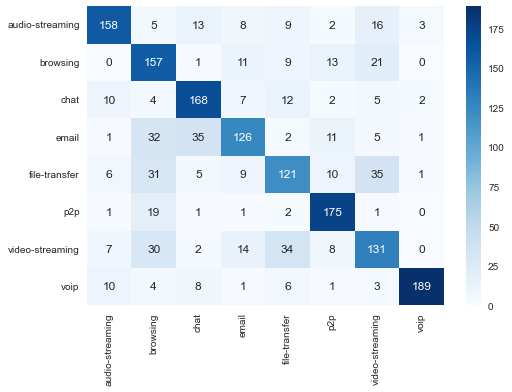

In [18]:
n_df = df_r.copy()
n_df = n_df.drop(['Y', 'YHat', 'Correct'], axis=1)

# n_df.pivot_table(index='label', columns='prediction', fill_value=0, aggfunc=np.sum)
cf = sklearn.metrics.confusion_matrix(df_r['label'], df_r['prediction'])
sns.heatmap(cf, annot=True, fmt='d', xticklabels=classes, yticklabels=classes, cmap='Blues')

<AxesSubplot:>

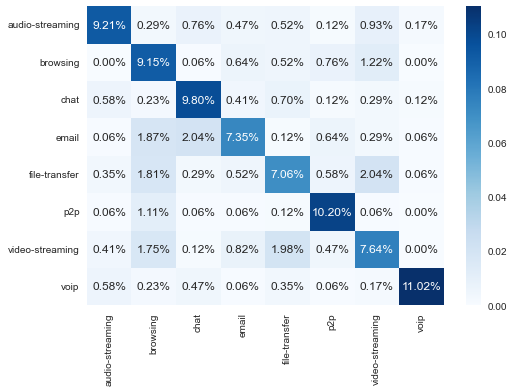

In [19]:
sns.heatmap(cf/np.sum(cf), annot=True, fmt='.2%', xticklabels=classes, yticklabels=classes, cmap='Blues')


# Setting up a more complex model: Resnet for Tabular Data

In [20]:
y_range     = None
epochs      = 10
classes     = data.classes
cardinality = [1 for _ in range(10)]
layers      = [100 for _ in range(10)]
n_out       = get_c(data.dls)
emb_szs     = get_emb_sz(data.dls.train_ds)


model       = ResidualTabularModel(emb_szs, len(data.dls.cont_names), n_out, layers, y_range=y_range, cardinality=cardinality)
criterion   = nn.CrossEntropyLoss()
optimizer   = torch.optim.Adam(model.parameters(), lr=0.01)

Layer sizes: [64, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 8], length: 12
Number of residual blocks: 9
Residual locations:  [1, 2, 3, 4, 5, 6, 7, 8, 9]


In [21]:
X_train = torch.LongTensor(data.X_train.values)
X_test = torch.LongTensor(data.X_test.values)
y_train = torch.LongTensor(data.y_train)
y_test = torch.LongTensor(data.y_test)

In [ ]:
# losses = []

# for i in range(epochs):
#     y_pred = model.forward(X_train)
#     loss = criterion(y_pred, y_train)
#     losses.append(loss)
#     print(f'epoch: {i:2}  loss: {loss.item():10.8f}')
    
#     optimizer.zero_grad()
#     loss.backward()
#     optimizer.step()

# # preds = []
# # with torch.no_grad():
# #     for val in X_test:
# #         y_hat = model.forward(val)
# #         preds.append(y_hat.argmax().item())

In [28]:
@delegates(Learner.__init__)
def residual_tabular_learner(dls, layers=None, emb_szs=None, config=None, n_out=None, y_range=None, cardinality=None, ps=None, **kwargs):
    "Get a `Learner` using `dls`, with `metrics`, including a `TabularModel` created using the remaining params."
    if config is None: config = tabular_config()
    if layers is None: layers = [200,100]
    to = dls.train_ds
    emb_szs = get_emb_sz(dls.train_ds, {} if emb_szs is None else emb_szs)
    if n_out is None: n_out = get_c(dls)
    assert n_out, "`n_out` is not defined, and could not be inferred from data, set `dls.c` or pass `n_out`"
    if y_range is None and 'y_range' in config: y_range = config.pop('y_range')
    model = ResidualTabularModel(emb_szs, len(dls.cont_names), n_out, layers, y_range=y_range, cardinality=cardinality, ps=ps, **config)
    return TabularLearner(dls, model, **kwargs)

In [24]:
learner = residual_tabular_learner(data.dls, layers=layers, cardinality=cardinality, n_out=get_c(data.dls), metrics=[accuracy, F1Score(average='macro')])

Layer sizes: [64, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 8], length: 12
Number of residual blocks: 9
Residual locations:  [1, 2, 3, 4, 5, 6, 7, 8, 9]


In [25]:
with learner.no_bar():
    learner.fit_one_cycle(epochs)
    

[0, 2.505378484725952, 1.8704004287719727, 0.4087463617324829, 0.39592573211585813, '00:02']
[1, 1.5464025735855103, 1.3311010599136353, 0.5883381962776184, 0.5878805806484689, '00:02']
[2, 1.2590309381484985, 1.1962820291519165, 0.6081632375717163, 0.6080147357030732, '00:02']
[3, 1.1323846578598022, 1.125893235206604, 0.6320699453353882, 0.632344059578636, '00:02']
[4, 1.0703219175338745, 1.084389567375183, 0.6489796042442322, 0.6504598263696455, '00:02']
[5, 1.0132803916931152, 1.0362855195999146, 0.6641399264335632, 0.6629495152039329, '00:02']
[6, 0.968506395816803, 1.0084152221679688, 0.6711370348930359, 0.6713521961042684, '00:02']
[7, 0.9287639856338501, 0.9837267398834229, 0.6787171959877014, 0.6796238757548416, '00:02']
[8, 0.9343493580818176, 0.9902156591415405, 0.6752186417579651, 0.6759821738671563, '00:02']
[9, 0.9099138975143433, 0.9834046363830566, 0.6798833608627319, 0.6805939761796318, '00:02']


(#3) [0.9834046363830566,0.6798833608627319,0.6805939761796318]

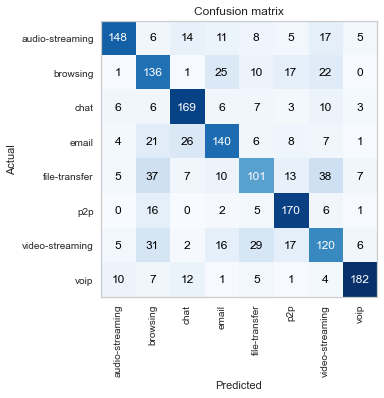

In [26]:
with learner.no_bar():
    results = learner.validate()
    interp = ClassificationInterpretation.from_learner(learner)
    interp.plot_confusion_matrix()

results

In [29]:
from fastai.torch_core import Enum



NormType = Enum('NormType', 'Batch BatchZero Weight Spectral Instance InstanceZero')

def _get_norm(prefix, nf, ndim=2, zero=False, **kwargs):
    "Norm layer with `nf` features and `ndim` initialized depending on `norm_type`."
    assert 1 <= ndim <= 3
    bn = getattr(nn, f"{prefix}{ndim}d")(nf, **kwargs)
    if bn.affine:
        bn.bias.data.fill_(1e-3)
        bn.weight.data.fill_(0. if zero else 1.)
    return bn
    
@delegates(nn.BatchNorm2d)
def BatchNorm(nf, ndim=2, norm_type=NormType.Batch, **kwargs):
    "BatchNorm layer with `nf` features and `ndim` initialized depending on `norm_type`."
    return _get_norm('BatchNorm', nf, ndim, zero=norm_type==NormType.BatchZero, **kwargs)



class LinBnDrop(nn.Sequential):
    "Module grouping `BatchNorm1d`, `Dropout` and `Linear` layers"
    def __init__(self, n_in, n_out, bn=True, p=0., act=nn.ReLU(inplace=True), lin_first=False):
        layers = [BatchNorm(n_out if lin_first else n_in, ndim=1)] if bn else []
        if p != 0: layers.append(nn.Dropout(p))
        lin = [nn.Linear(n_in, n_out, bias=not bn)]
        if act is not None: lin.append(act)
        layers = lin+layers if lin_first else layers+lin
        super().__init__(*layers)

In [30]:
class Simple_Resnet_Model(nn.Module):
    def __init__(self, input_features=62, layers=[100 for _ in range(20)], output_features=8):
        super().__init__()
        self._layers = []
        _activations = [nn.ReLU(inplace=True) for _ in range(len(layers) - 1)] + [None]
        # _activations = [nn.ReLU(inplace=True) for _ in range(len(layers))]
        # _activations = [nn.ReLU(inplace=True)] * len(layers)



        for i, x in enumerate(layers):
            print(i)
            if (i == 0):
                print(f'i = {i} == 0')
                self._layers.append(BottleneckResidualBlock([LinBnDrop(input_features, layers[i+1], act=_activations[i], lin_first=True)], i, input_features, layers[i+1]))
            elif (i == len(layers) - 1):
                print(f'i = {i} == {len(layers) - 1}')
                self._layers.append(BottleneckResidualBlock([LinBnDrop(x, output_features, act=_activations[i], lin_first=True)], i, x, output_features))
                # self._layers.append(LinBnDrop(x, output_features, act=_activations[i], lin_first=True))
            else:
                self._layers.append(BottleneckResidualBlock([LinBnDrop(x, layers[i+1], act=_activations[i], lin_first=True)], i, x, layers[i+1]))
        


        self.out = nn.Sequential(*self._layers)     
        
    def forward(self, x):
        # for i, layer in enumerate(self._layers):
            # print('layer', i)
            # x = layer(x)

        return self.out(x)




In [32]:
epochs    = 10
classes   = data.classes
model     = Simple_Resnet_Model(input_features=62, output_features=len(classes))
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
# model

0
i = 0 == 0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
i = 19 == 19


In [33]:
X_train = torch.FloatTensor(data.X_train.values)
X_test = torch.FloatTensor(data.X_test.values)
y_train = torch.LongTensor(data.y_train)
y_test = torch.LongTensor(data.y_test)

In [34]:
losses = []

for i in range(epochs):
    y_pred = model.forward(X_train)
    loss = criterion(y_pred, y_train)
    losses.append(loss)
    print(f'epoch: {i:2}  loss: {loss.item():10.8f}')
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


epoch:  0  loss: 2.34404159
epoch:  1  loss: 1.99837220
epoch:  2  loss: 1.80483472
epoch:  3  loss: 1.69817483
epoch:  4  loss: 1.61650741
epoch:  5  loss: 1.54333127
epoch:  6  loss: 1.48491013
epoch:  7  loss: 1.43334508
epoch:  8  loss: 1.38615465
epoch:  9  loss: 1.34541559


In [35]:

preds = []
with torch.no_grad():

    predictions = model.forward(X_test)
    preds = predictions.argmax(dim=1).numpy()



    # for val in X_test:
    #     y_hat = model.forward(val.view((1,1,62)))
    #     preds.append(y_hat.argmax().item())

In [36]:
df_r = pd.DataFrame({'Y': y_test, 'YHat': preds})
df_r['Correct'] = [1 if corr == pred else 0 for corr, pred in zip(df_r['Y'], df_r['YHat'])]
df_r['label'] = df_r['Y'].apply(lambda x: classes[x])
df_r['prediction'] = df_r['YHat'].apply(lambda x: classes[x])

In [37]:
df_r['Correct'].sum() / len(df_r)

0.5807580174927114

<AxesSubplot:>

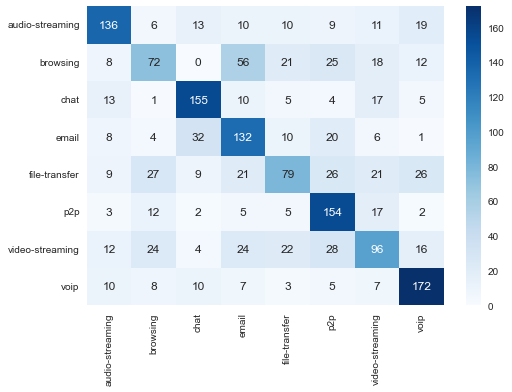

In [38]:
n_df = df_r.copy()
n_df = n_df.drop(['Y', 'YHat', 'Correct'], axis=1)

# n_df.pivot_table(index='label', columns='prediction', fill_value=0, aggfunc=np.sum)
cf = sklearn.metrics.confusion_matrix(df_r['label'], df_r['prediction'])
sns.heatmap(cf, annot=True, fmt='d', xticklabels=classes, yticklabels=classes, cmap='Blues')

In [39]:
import spdlayers
import rff

In [40]:
X_train.shape

torch.Size([6861, 62])

In [41]:
encoding = rff.layers.GaussianEncoding(sigma=10.0, input_size=62, encoded_size=62)

In [42]:
Xp = encoding(X_train)

In [43]:
Xp.shape

torch.Size([6861, 124])

In [44]:



class BnReluLin(nn.Sequential):
    "Module grouping `BatchNorm1d`, `Relu` and `Linear` layers"
    def __init__(self, n_in, n_out, act=nn.ReLU(inplace=True)):
        layers = [
            BatchNorm(n_in, ndim=1),
            act,
            nn.Linear(n_in, n_out, bias=False)
        ]
        super().__init__(*layers)


In [45]:
class BottleneckResidualBlock(Module):
    '''
        A residule block that creates a skip connection around a set of n branches
            where the number of branches is determined by the number of input modules
            in the branches list parameter.

            the residual connection is put through a linear batchnormed layer if the
            input size is different from the output size
            Then, the output of the branches is summed together along with the possibly transformed input
    '''
    def __init__(self, branches: list, layer: int, in_size: int, out_size: int):
        self.branches = branches
        self.layer = layer

        self.in_size = in_size
        self.out_size = out_size

        self.linear = LinBnDrop(in_size, out_size, lin_first=True, act=nn.ReLU(inplace=True))
        # self.linear = BnReluLin(in_size, out_size)

    def forward(self, inputs):
        fx = self.branches[0](inputs)
        for i in range(len(self.branches) - 1):
            fx += self.branches[i + 1](inputs)

        if(inputs.shape != fx.shape):
            inputs = self.linear(inputs)
        return fx + inputs



In [46]:

# class ResNet_MLP(nn.Module):

class ResNet_MLP(Module):
    def __init__(self, input_features=62, output_features=8, config={'layers': [100 for _ in range(20)], 'cardinality':[1 for _ in range(20)]}):
        # super().__init__()

        cardinality  = config['cardinality']
        layers       = config['layers']
        _layers = []

        for i, x in enumerate(layers):
            if (i == 0):
                _layers.append(
                    BottleneckResidualBlock(
                        [   
                            BnReluLin(2*(input_features//2), layers[i+1]) for _ in range(cardinality[i])
                        ], 
                        i,
                        input_features, 
                        layers[i+1]
                    )
                )
            elif (i == len(layers) - 1):
                # _layers.append(BottleneckResidualBlock(
                #     [
                #         BnReluLin(x, output_features)
                #     ], 
                #     i, x, output_features)
                # )

                _layers.append(BnReluLin(x, output_features))
                # _layers.append(LinBnDrop(x, output_features))
            else:
                _layers.append(
                    BottleneckResidualBlock(
                        [
                            BnReluLin(x, layers[i+1]) for _ in range(cardinality[i])
                        ], 
                        i, 
                        x, 
                        layers[i+1]
                    )
                )

        self.layers = nn.Sequential(*_layers)     
        
    def forward(self, x):
        return self.layers(x)




In [47]:
class Torch_Model_Loader(Module):
    "Loads a torch model and allows use of the fastai scheduler and optimizer"
    def __init__(self, emb_szs, n_cont, out_sz, model=None, embed_p=0., y_range=None, bn_cont=True, config={'layers': [100 for _ in range(20)], 'cardinality':[1 for _ in range(20)]}):
    
        # setup for the model using Fastai's system of embedding categorical features
    
        self.embeds   = nn.ModuleList([Embedding(ni, nf) for ni,nf in emb_szs])
        self.emb_drop = nn.Dropout(embed_p)
        self.bn_cont  = nn.BatchNorm1d(n_cont) if bn_cont else None
        self.n_emb    = sum(e.embedding_dim for e in self.embeds)
        self.in_sz    = self.n_emb + n_cont
        self.n_cont   = n_cont
        
        
        if(model == None):
            model = ResNet_MLP
        self.model = model(input_features=self.in_sz, output_features=out_sz, config=config)


        _layers: list = []
        _layers.append(self.model)


        if y_range is not None: _layers.append(SigmoidRange(*y_range))
        self.loader = nn.Sequential(*_layers)



    def forward(self, x_cat, x_cont=None):
        if self.n_emb != 0:
            x = [e(x_cat[:,i]) for i,e in enumerate(self.embeds)]
            x = torch.cat(x, 1)
            x = self.emb_drop(x)
        if self.n_cont != 0:
            if self.bn_cont is not None: x_cont = self.bn_cont(x_cont)
            x = torch.cat([x, x_cont], 1) if self.n_emb != 0 else x_cont
        return self.loader(x)


In [48]:
@delegates(Learner.__init__)
def torch_learner(dls, model=None, emb_szs=None, n_out=None, config={'layers': [100 for _ in range(20)], 'cardinality':[1 for _ in range(20)]}, y_range=None, **kwargs):
    '''
        Creates a Fastai Learner using a dataloader and passed in model 
            model parameters are passed in through config
            Tabular learner parameters are passed in as additional kwargs
    
        returns a Fastai TabularModel created using the remaining params
    '''
    emb_szs = get_emb_sz(dls.train_ds, {} if emb_szs is None else emb_szs)
    if n_out is None: 
        n_out = get_c(dls)
    
    # option to scale outputs to a certain range, uses a sigmoid function
    if y_range is None and 'y_range' in config: 
        y_range = config.pop('y_range')

    md = Torch_Model_Loader(emb_szs, len(dls.cont_names), n_out, config=config, y_range=y_range, model=model)

    return TabularLearner(dls, md, **kwargs)

In [226]:
new_to = TabularDataLoaders.from_df(balanced_df_1, cat_names=['Protocol'], y_names='Application Type')

In [227]:
new_to.xs.head()

,Protocol,Bwd IAT Max,Packet Length Min,Fwd Segment Size Avg,Bwd Segment Size Avg,Bwd Packet Length Std,Flow Bytes/s,Packet Length Variance,Idle Max,Fwd Packets/s,Subflow Bwd Bytes,Bwd Packet/Bulk Avg,Fwd Packet Length Std,Fwd PSH Flags,ACK Flag Count,FWD Init Win Bytes,Fwd Act Data Pkts,Fwd IAT Mean,Total Fwd Packet,Flow IAT Max,RST Flag Count,PSH Flag Count,Fwd Packet Length Max,FIN Flag Count,Down/Up Ratio,Bwd Packets/s,Flow IAT Std,Fwd IAT Std,Fwd IAT Min,Idle Mean,Bwd IAT Total,Subflow Fwd Bytes,Total Length of Fwd Packet,Bwd IAT Mean,Fwd IAT Max,Packet Length Mean,Subflow Fwd Packets,Idle Std,Fwd Packet Length Mean,Bwd Packet Length Mean,Flow Duration,Flow IAT Mean,Total Bwd packets,SYN Flag Count,Flow IAT Min,Fwd Packet Length Min,Packet Length Std,Idle Min,Average Packet Size,Bwd Packet Length Max,Bwd Bulk Rate Avg,Bwd Packet Length Min,Bwd Init Win Bytes,Packet Length Max,Fwd Seg Size Min,Total Length of Bwd Packet,Bwd IAT Min,Bwd IAT Std,Fwd IAT Total,Bwd Header Length,Fwd Header Length,Flow Packets/s
981,17,0,33,33.000000,345.000000,0.000000,601910.812500,32448.000000,0.000000e+00,1592.356689,172,0,0.000000,0,0,0,0,0.0,1,628,0,0,33,0,1,1592.356689,0.0,0.0,0,0.000000e+00,0,16,33,0.0,0,137.000000,0,0.0,33.000000,345.000000,628,628.0,1,0,628,33,180.133286,0.000000e+00,205.500000,345,0,345,0,345,8,345,0,0.0,0,8,8,3184.713379
947,6,45055264,0,0.000000,25.666666,40.083248,1.465982,909.969727,1.437770e+15,0.047597,14,0,0.000000,0,11,2190,0,26262252.0,5,45054988,0,2,0,1,1,0.057116,18782528.0,22516898.0,110525,1.437770e+15,105047636,0,0,21009528.0,45056376,12.833333,0,38802784.0,0.000000,25.666666,105049024,10504902.0,6,0,11,0,30.165705,1.437770e+15,14.000000,85,0,0,1176,85,20,154,24,22757608.0,105049011,120,100,0.104713
8543,17,0,32,32.000000,82.000000,0.000000,942.865662,833.333313,0.000000e+00,8.270751,41,0,0.000000,0,0,0,0,0.0,1,120908,0,0,32,0,1,8.270751,0.0,0.0,0,0.000000e+00,0,16,32,0.0,0,48.666668,0,0.0,32.000000,82.000000,120908,120908.0,1,0,120908,32,28.867514,0.000000e+00,73.000000,82,0,82,0,82,8,82,0,0.0,0,8,8,16.541502
2274,17,0,37,37.000000,213.000000,0.000000,2030.786743,10325.333008,0.000000e+00,8.123147,106,0,0.000000,0,0,0,0,0.0,1,123105,0,0,37,0,1,8.123147,0.0,0.0,0,0.000000e+00,0,18,37,0.0,0,95.666664,0,0.0,37.000000,213.000000,123105,123105.0,1,0,123105,37,101.613647,0.000000e+00,143.500000,213,0,213,0,213,8,213,0,0.0,0,8,8,16.246294
31,6,58999233,0,250.454544,107.888885,255.776489,31.602816,228696.734375,1.429040e+15,0.093299,48,7,518.334106,0,20,353,5,11790089.0,11,58937664,0,10,1338,0,0,0.076335,18546348.0,24801298.0,9,1.429040e+15,117875312,137,2755,14734414.0,58937664,241.142853,0,41487168.0,250.454544,107.888885,117900890,6205310.0,9,0,9,0,478.222473,1.429040e+15,253.199997,787,30242,0,425,1338,32,971,59,27246622.0,117900890,288,352,0.169634


In [238]:
df = balanced_df_1

target_label = 'Application Type'
categorical  = ['Protocol']
leave_out    = []

categorical_features: list = []
untouched_features  : list = []


for x in leave_out:
    if x in df.columns:
        untouched_features.append(x)

for x in categorical:
    if x in df.columns:
        categorical_features.append(x)


continuous_features = list(set(df) - set(categorical_features) - set([target_label]) - set(untouched_features))


splits = RandomSplitter(valid_pct=.2, seed=seed)(range_of(df))


# The dataframe is loaded into a fastai datastructure now that 
# the feature engineering pipeline has been set up
to = TabularPandas(
    df            , y_names=target_label                , 
    splits=splits , cat_names=categorical_features ,
    cont_names=continuous_features , 
)
to.xs.head()

,Protocol,Bwd IAT Max,Packet Length Min,Fwd Segment Size Avg,Bwd Segment Size Avg,Bwd Packet Length Std,Flow Bytes/s,Packet Length Variance,Idle Max,Fwd Packets/s,Subflow Bwd Bytes,Bwd Packet/Bulk Avg,Fwd Packet Length Std,Fwd PSH Flags,ACK Flag Count,FWD Init Win Bytes,Fwd Act Data Pkts,Fwd IAT Mean,Total Fwd Packet,Flow IAT Max,RST Flag Count,PSH Flag Count,Fwd Packet Length Max,FIN Flag Count,Down/Up Ratio,Bwd Packets/s,Flow IAT Std,Fwd IAT Std,Fwd IAT Min,Idle Mean,Bwd IAT Total,Subflow Fwd Bytes,Total Length of Fwd Packet,Bwd IAT Mean,Fwd IAT Max,Packet Length Mean,Subflow Fwd Packets,Idle Std,Fwd Packet Length Mean,Bwd Packet Length Mean,Flow Duration,Flow IAT Mean,Total Bwd packets,SYN Flag Count,Flow IAT Min,Fwd Packet Length Min,Packet Length Std,Idle Min,Average Packet Size,Bwd Packet Length Max,Bwd Bulk Rate Avg,Bwd Packet Length Min,Bwd Init Win Bytes,Packet Length Max,Fwd Seg Size Min,Total Length of Bwd Packet,Bwd IAT Min,Bwd IAT Std,Fwd IAT Total,Bwd Header Length,Fwd Header Length,Flow Packets/s
5198,6,0,0,0.0,0.0,0.0,0.000000,0.000000,0.0,1658.374756,0,0,0.0,0,2,993,0,0.0,1,603,0,0,0,1,1,1658.374756,0.0,0.0,0,0.0,0,0,0,0.0,0,0.000000,0,0.0,0.0,0.0,603,603.0,1,0,603,0,0.000000,0.0,0.0,0,0,0,1247,0,20,0,0,0.0,0,20,20,3316.749512
8488,17,0,42,42.0,114.0,0.0,1284.489746,1728.000000,0.0,8.233909,57,0,0.0,0,0,0,0,0.0,1,121449,0,0,42,0,1,8.233909,0.0,0.0,0,0.0,0,21,42,0.0,0,66.000000,0,0.0,42.0,114.0,121449,121449.0,1,0,121449,42,41.569218,0.0,99.0,114,0,114,0,114,8,114,0,0.0,0,8,8,16.467817
3522,6,0,0,0.0,0.0,0.0,0.000000,0.000000,0.0,38461.539062,0,0,0.0,0,0,0,0,52.0,2,52,2,0,0,0,0,0.000000,0.0,0.0,52,0.0,0,0,0,0.0,52,0.000000,1,0.0,0.0,0.0,52,52.0,0,0,52,0,0.000000,0.0,0.0,0,0,0,0,0,20,0,0,0.0,52,0,40,38461.539062
5727,17,0,73,73.0,0.0,0.0,4.847789,0.000000,30116820.0,0.066408,0,0,0.0,0,0,0,1,30116820.0,2,30116820,0,0,73,0,0,0.000000,0.0,0.0,30116820,30116820.0,0,73,146,0.0,30116820,73.000000,1,0.0,73.0,0.0,30116820,30116820.0,0,0,30116820,73,0.000000,30116820.0,109.5,0,0,0,0,73,8,0,0,0.0,30116820,0,16,0.066408
2508,17,0,33,33.0,224.0,0.0,1951.775146,12160.333008,0.0,7.594456,112,0,0.0,0,0,0,0,0.0,1,131675,0,0,33,0,1,7.594456,0.0,0.0,0,0.0,0,16,33,0.0,0,96.666664,0,0.0,33.0,224.0,131675,131675.0,1,0,131675,33,110.273903,0.0,145.0,224,0,224,0,224,8,224,0,0.0,0,8,8,15.188912


In [239]:
to.procs = data.to.procs
to.xs.head()

,Protocol,Bwd IAT Max,Packet Length Min,Fwd Segment Size Avg,Bwd Segment Size Avg,Bwd Packet Length Std,Flow Bytes/s,Packet Length Variance,Idle Max,Fwd Packets/s,Subflow Bwd Bytes,Bwd Packet/Bulk Avg,Fwd Packet Length Std,Fwd PSH Flags,ACK Flag Count,FWD Init Win Bytes,Fwd Act Data Pkts,Fwd IAT Mean,Total Fwd Packet,Flow IAT Max,RST Flag Count,PSH Flag Count,Fwd Packet Length Max,FIN Flag Count,Down/Up Ratio,Bwd Packets/s,Flow IAT Std,Fwd IAT Std,Fwd IAT Min,Idle Mean,Bwd IAT Total,Subflow Fwd Bytes,Total Length of Fwd Packet,Bwd IAT Mean,Fwd IAT Max,Packet Length Mean,Subflow Fwd Packets,Idle Std,Fwd Packet Length Mean,Bwd Packet Length Mean,Flow Duration,Flow IAT Mean,Total Bwd packets,SYN Flag Count,Flow IAT Min,Fwd Packet Length Min,Packet Length Std,Idle Min,Average Packet Size,Bwd Packet Length Max,Bwd Bulk Rate Avg,Bwd Packet Length Min,Bwd Init Win Bytes,Packet Length Max,Fwd Seg Size Min,Total Length of Bwd Packet,Bwd IAT Min,Bwd IAT Std,Fwd IAT Total,Bwd Header Length,Fwd Header Length,Flow Packets/s
5198,6,0,0,0.0,0.0,0.0,0.000000,0.000000,0.0,1658.374756,0,0,0.0,0,2,993,0,0.0,1,603,0,0,0,1,1,1658.374756,0.0,0.0,0,0.0,0,0,0,0.0,0,0.000000,0,0.0,0.0,0.0,603,603.0,1,0,603,0,0.000000,0.0,0.0,0,0,0,1247,0,20,0,0,0.0,0,20,20,3316.749512
8488,17,0,42,42.0,114.0,0.0,1284.489746,1728.000000,0.0,8.233909,57,0,0.0,0,0,0,0,0.0,1,121449,0,0,42,0,1,8.233909,0.0,0.0,0,0.0,0,21,42,0.0,0,66.000000,0,0.0,42.0,114.0,121449,121449.0,1,0,121449,42,41.569218,0.0,99.0,114,0,114,0,114,8,114,0,0.0,0,8,8,16.467817
3522,6,0,0,0.0,0.0,0.0,0.000000,0.000000,0.0,38461.539062,0,0,0.0,0,0,0,0,52.0,2,52,2,0,0,0,0,0.000000,0.0,0.0,52,0.0,0,0,0,0.0,52,0.000000,1,0.0,0.0,0.0,52,52.0,0,0,52,0,0.000000,0.0,0.0,0,0,0,0,0,20,0,0,0.0,52,0,40,38461.539062
5727,17,0,73,73.0,0.0,0.0,4.847789,0.000000,30116820.0,0.066408,0,0,0.0,0,0,0,1,30116820.0,2,30116820,0,0,73,0,0,0.000000,0.0,0.0,30116820,30116820.0,0,73,146,0.0,30116820,73.000000,1,0.0,73.0,0.0,30116820,30116820.0,0,0,30116820,73,0.000000,30116820.0,109.5,0,0,0,0,73,8,0,0,0.0,30116820,0,16,0.066408
2508,17,0,33,33.0,224.0,0.0,1951.775146,12160.333008,0.0,7.594456,112,0,0.0,0,0,0,0,0.0,1,131675,0,0,33,0,1,7.594456,0.0,0.0,0,0.0,0,16,33,0.0,0,96.666664,0,0.0,33.0,224.0,131675,131675.0,1,0,131675,33,110.273903,0.0,145.0,224,0,224,0,224,8,224,0,0.0,0,8,8,15.188912


In [240]:
to.process()
to.xs.head()


,Protocol,Bwd IAT Max,Packet Length Min,Fwd Segment Size Avg,Bwd Segment Size Avg,Bwd Packet Length Std,Flow Bytes/s,Packet Length Variance,Idle Max,Fwd Packets/s,Subflow Bwd Bytes,Bwd Packet/Bulk Avg,Fwd Packet Length Std,Fwd PSH Flags,ACK Flag Count,FWD Init Win Bytes,Fwd Act Data Pkts,Fwd IAT Mean,Total Fwd Packet,Flow IAT Max,RST Flag Count,PSH Flag Count,Fwd Packet Length Max,FIN Flag Count,Down/Up Ratio,Bwd Packets/s,Flow IAT Std,Fwd IAT Std,Fwd IAT Min,Idle Mean,Bwd IAT Total,Subflow Fwd Bytes,Total Length of Fwd Packet,Bwd IAT Mean,Fwd IAT Max,Packet Length Mean,Subflow Fwd Packets,Idle Std,Fwd Packet Length Mean,Bwd Packet Length Mean,Flow Duration,Flow IAT Mean,Total Bwd packets,SYN Flag Count,Flow IAT Min,Fwd Packet Length Min,Packet Length Std,Idle Min,Average Packet Size,Bwd Packet Length Max,Bwd Bulk Rate Avg,Bwd Packet Length Min,Bwd Init Win Bytes,Packet Length Max,Fwd Seg Size Min,Total Length of Bwd Packet,Bwd IAT Min,Bwd IAT Std,Fwd IAT Total,Bwd Header Length,Fwd Header Length,Flow Packets/s
5198,2,-0.411893,-0.741675,-0.391091,-0.587303,-0.419938,-0.144714,-0.471265,-0.935963,-0.166884,-0.529021,-0.13778,-0.468483,-0.34241,-0.12171,-0.405401,-0.100964,-0.322518,-0.128165,-0.477605,-0.206780,-0.128332,-0.462477,1.232562,0.632246,-0.094528,-0.381092,-0.324075,-0.234541,-0.926839,-0.488276,-0.322498,-0.075837,-0.279751,-0.458848,-0.553093,-0.529637,-0.241765,-0.391091,-0.587303,-0.544849,-0.327022,-0.137874,-0.499903,-0.136726,-0.633036,-0.683265,-0.816122,-0.618282,-0.548037,-0.162701,-0.520069,-0.144293,-0.594290,0.518093,-0.088577,-0.188213,-0.303613,-0.530027,-0.122284,-0.121955,-0.140102
8488,3,-0.411893,1.235352,-0.222626,-0.108538,-0.419938,-0.142205,-0.455727,-0.935963,-0.216717,-0.115804,-0.13778,-0.468483,-0.34241,-0.12220,-0.482172,-0.100964,-0.322518,-0.128165,-0.470762,-0.206780,-0.128332,-0.380949,-0.727709,0.632246,-0.154061,-0.381092,-0.324075,-0.234541,-0.926839,-0.488276,-0.216112,-0.075821,-0.279751,-0.458848,-0.271257,-0.529637,-0.241765,-0.222626,-0.108538,-0.541807,-0.307809,-0.137874,-0.499903,-0.111960,0.928633,-0.463346,-0.816122,-0.201795,-0.315450,-0.162701,0.471373,-0.254055,-0.407256,-0.973988,-0.088519,-0.188213,-0.303613,-0.530027,-0.122539,-0.122212,-0.196861
3522,2,-0.411893,-0.741675,-0.391091,-0.587303,-0.419938,-0.144714,-0.471265,-0.935963,0.944532,-0.529021,-0.13778,-0.468483,-0.34241,-0.12220,-0.482172,-0.100964,-0.322513,-0.127730,-0.477636,4.924203,-0.128332,-0.462477,-0.727709,-1.161732,-0.154358,-0.381092,-0.324075,-0.234536,-0.926839,-0.488276,-0.322498,-0.075837,-0.279751,-0.458845,-0.553093,1.888086,-0.241765,-0.391091,-0.587303,-0.544863,-0.327110,-0.138354,-0.499903,-0.136839,-0.633036,-0.683265,-0.816122,-0.618282,-0.548037,-0.162701,-0.520069,-0.254055,-0.594290,0.518093,-0.088577,-0.188213,-0.303613,-0.530025,-0.122708,-0.121527,0.464328
5727,3,-0.411893,2.694586,-0.098284,-0.587303,-0.419938,-0.144704,-0.471265,-0.935963,-0.216964,-0.529021,-0.13778,-0.468483,-0.34241,-0.12220,-0.482172,-0.100485,2.418397,-0.127730,1.227794,-0.206780,-0.128332,-0.320773,-0.727709,-1.161732,-0.154358,-0.381092,-0.324075,2.709122,-0.926839,-0.488276,0.047320,-0.075781,-0.279751,1.265194,-0.241365,1.888086,-0.241765,-0.098284,-0.587303,0.213388,4.461095,-0.138354,-0.499903,6.035292,2.081293,-0.683265,-0.816122,-0.157622,-0.548037,-0.162701,-0.520069,-0.254055,-0.474523,-0.973988,-0.088577,-0.188213,-0.303613,0.234027,-0.122708,-0.122041,-0.197143
2508,3,-0.411893,0.811703,-0.258726,0.353428,-0.419938,-0.140902,-0.361917,-0.935963,-0.216736,0.282915,-0.13778,-0.468483,-0.34241,-0.12220,-0.482172,-0.100964,-0.322518,-0.128165,-0.470183,-0.206780,-0.128332,-0.398419,-0.727709,0.632246,-0.154084,-0.381092,-0.324075,-0.234541,-0.926839,-0.488276,-0.241442,-0.075824,-0.279751,-0.458848,-0.140302,-0.529637,-0.241765,-0.258726,0.353428,-0.541549,-0.306183,-0.137874,-0.499903,-0.109864,0.593989,-0.099870,-0.816122,-0.008275,-0.091024,-0.162701,1.428028,-0.254055,-0.226785,-0.973988,-0.0

In [ ]:
def train_deep_model_on_new_df(
    model_data: Model_data,
    target_label: str, 
    split=0.2, 
    categorical: list = ['Protocol'],
    leave_out: list = [],
    epochs: int = 10,
    batch_size: int = 64,
    metrics: list or None = None,
    callbacks: list = [ShowGraphCallback],
    lr_choice: str = 'valley',
    name: str or None = None,
    fit_choice: str = 'one_cycle',
    no_bar: bool = False,
) -> Model_data:
    '''
    '''


    lr_choice = {'valley': 0, 'slide': 1, 'steep': 2, 'minimum': 3}[lr_choice]


    categorical_features: list = []
    untouched_features  : list = []

    for x in leave_out:
        if x in df.columns:
            untouched_features.append(x)

    for x in categorical:
        if x in df.columns:
            categorical_features.append(x)

        
    if metrics is None:
        metrics = [accuracy, BalancedAccuracy(), RocAuc(), MatthewsCorrCoef(), F1Score(average='macro'), Precision(average='macro'), Recall(average='macro')]


    continuous_features = list(set(df) - set(categorical_features) - set([target_label]) - set(untouched_features))

    splits = RandomSplitter(valid_pct=split, seed=seed)(range_of(df))


    # The dataframe is loaded into a fastai datastructure now that 
    # the feature engineering pipeline has been set up
    to = TabularPandas(
        df            , y_names=target_label                , 
        splits=splits , cat_names=categorical_features ,
        cont_names=continuous_features , 
    )

    # loads the transformations from the previous data loaders and applies them to the new data
    to.procs = model_data.to.procs
    to.process()

    # The dataframe is then converted into a fastai dataset
    dls = to.dataloaders(bs=batch_size)

    # extract the file_name from the path
    p = pathlib.Path(file_name)
    file_name: str = str(p.parts[-1])

    learner = torch_learner(dls, metrics=metrics, cbs=callbacks, config=None)
    learner.model = model_data.model.model.model

    with learner.no_bar() if no_bar else contextlib.ExitStack() as gs:

        lr = learner.lr_find(suggest_funcs=[valley, slide, steep, minimum])

            # fitting functions, they give different results, some networks perform better with different learning schedule during fitting
        if(fit_choice == 'fit'):
            learner.fit(epochs, lr[lr_choice])
        elif(fit_choice == 'flat_cos'):
            learner.fit_flat_cos(epochs, lr[lr_choice])
        elif(fit_choice == 'one_cycle'):
            learner.fit_one_cycle(epochs, lr_max=lr[lr_choice])
        else:
            assert False, f'{fit_choice} is not a valid fit_choice'

        learner.recorder.plot_sched() 
        results = learner.validate()
        interp = ClassificationInterpretation.from_learner(learner)
        interp.plot_confusion_matrix()
                

    print(f'loss: {results[0]}, accuracy: {results[1]*100: .2f}%')
    learner.save(f'{file_name}.model')


    X_train = to.train.xs.reset_index(drop=True)
    X_test = to.valid.xs.reset_index(drop=True)
    y_train = to.train.ys.values.ravel()
    y_test = to.valid.ys.values.ravel()

    wrapped_model = SklearnWrapper(learner)

    classes = list(learner.dls.vocab)
    if len(classes) == 2:
        wrapped_model.target_type_ = 'binary'
    elif len(classes) > 2:  
        wrapped_model.target_type_ = 'multiclass'
    else:
        print('Must be more than one class to perform classification')
        raise ValueError('Wrong number of classes')
    
    wrapped_model._target_labels = target_label
    
    model_data: Model_data = Model_data(file_name, wrapped_model, classes, X_train, y_train, X_test, y_test, to, dls, name)


    return model_data



Layer sizes: [64, 100, 100, 100, 100, 100, 8], length: 7
Number of residual blocks: 4
Residual locations:  [1, 2, 3, 4]


C:\ProgramData\Anaconda3\lib\site-packages\fastai\callback\schedule.py:270: UserWarning:

color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.



[0, 1.6290488243103027, 1.3858450651168823, 0.518367350101471, 0.521546199996875, 0.8513487045055463, 0.45300209362169874, 0.5090806360383313, 0.5190545035287533, 0.521546199996875, '00:01']
[1, 1.2288317680358887, 1.1537777185440063, 0.6174927353858948, 0.6201017419133417, 0.8957836925445577, 0.5645164262915626, 0.6141153161235808, 0.6188498134636795, 0.6201017419133417, '00:01']
[2, 1.0914814472198486, 1.074739694595337, 0.6483964920043945, 0.6510371216087298, 0.9086896488980047, 0.5994267176466512, 0.6470867987184725, 0.6517005313326729, 0.6510371216087298, '00:01']
[3, 1.020050048828125, 1.0495816469192505, 0.6489796042442322, 0.6514162409582562, 0.9135724842011369, 0.6004584070810753, 0.6483716088514417, 0.6573446504264997, 0.6514162409582562, '00:01']
[4, 0.9867330193519592, 1.0459071397781372, 0.649562656879425, 0.6522108367639274, 0.9142888856448501, 0.6020208257728681, 0.647657432900424, 0.6625674453189863, 0.6522108367639274, '00:01']
loss: 1.0459071397781372, accuracy:  64.9

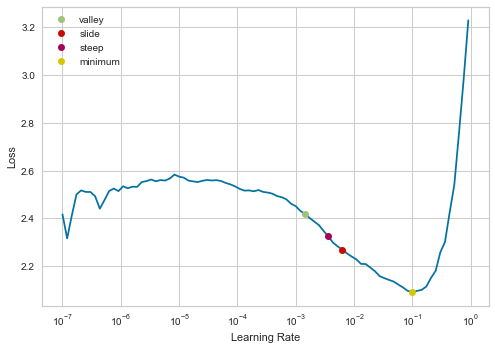

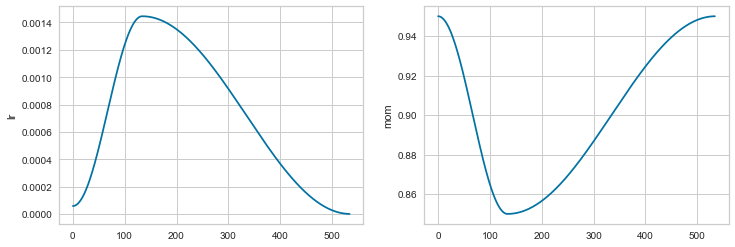

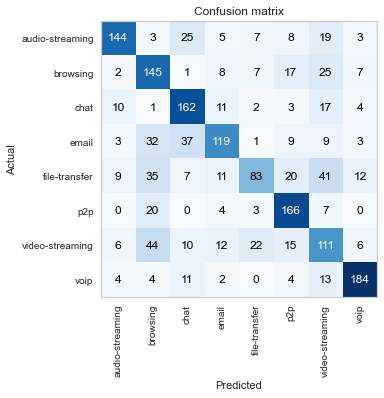

In [53]:
model_data_1 = run_residual_deep_nn_experiment(
    balanced_df,
    'none.csv',
    'Application Type',
    [100 for i in range(5)],
    epochs=5,
    callbacks=[],
    no_bar=True,
)

In [54]:
model_data_1.model.model.model

ResidualTabularModel(
  (embeds): ModuleList(
    (0): Embedding(4, 3)
  )
  (emb_drop): Dropout(p=0.0, inplace=False)
  (bn_cont): BatchNorm1d(61, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): LinBnDrop(
      (0): Linear(in_features=64, out_features=100, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BottleneckResidualBlock(
      (linear): LinBnDrop(
        (0): Linear(in_features=100, out_features=100, bias=False)
        (1): ReLU(inplace=True)
        (2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): BottleneckResidualBlock(
      (linear): LinBnDrop(
        (0): Linear(in_features=100, out_features=100, bias=False)
        (1): ReLU(inplace=True)
        (2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (3): Bottlen

In [190]:
y_range     = None
epochs      = 20
classes     = data.classes
cardinality = [4 for _ in range(3)]
layers      = [50 for _ in range(3)]
n_out       = get_c(data.dls)
emb_szs     = get_emb_sz(data.dls.train_ds)

logger_1 = DFLogger()
collector_1 = ModelStatsCallback()
grapher_1 = LazyGraphCallback()
# model_saver = SaveModelCallback(monitor='f1_score')
model_saver = SaveModelCallback(monitor='balanced_accuracy_score')
callbacks_1 = [model_saver, logger_1, collector_1, grapher_1]
# callbacks_1 = [logger_1, collector_1, grapher_1]
config = {'layers': layers, 'cardinality': cardinality, 'enc_sz': 50}
metrics=[accuracy, BalancedAccuracy(),  F1Score(average='macro')]

In [191]:
learner = torch_learner(data.dls, metrics=metrics, cbs=callbacks_1, config=config)

In [192]:
learner.model

Torch_Model_Loader(
  (embeds): ModuleList(
    (0): Embedding(4, 3)
  )
  (emb_drop): Dropout(p=0.0, inplace=False)
  (bn_cont): BatchNorm1d(61, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (model): ResNet_MLP(
    (layers): Sequential(
      (0): BottleneckResidualBlock(
        (linear): LinBnDrop(
          (0): Linear(in_features=64, out_features=50, bias=False)
          (1): ReLU(inplace=True)
          (2): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (1): BottleneckResidualBlock(
        (linear): LinBnDrop(
          (0): Linear(in_features=50, out_features=50, bias=False)
          (1): ReLU(inplace=True)
          (2): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): BnReluLin(
        (0): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU(inplace=True)
        (2): Linear(in_features=50, 

Better model found at epoch 0 with balanced_accuracy_score value: 0.18401261590767343.
Better model found at epoch 1 with balanced_accuracy_score value: 0.34354949510404276.
Better model found at epoch 2 with balanced_accuracy_score value: 0.5462670463949031.
Better model found at epoch 3 with balanced_accuracy_score value: 0.5748972876658647.
Better model found at epoch 4 with balanced_accuracy_score value: 0.5998900201045236.
Better model found at epoch 5 with balanced_accuracy_score value: 0.6266960222166353.
Better model found at epoch 6 with balanced_accuracy_score value: 0.64208363565659.
Better model found at epoch 8 with balanced_accuracy_score value: 0.6531064149115466.
Better model found at epoch 9 with balanced_accuracy_score value: 0.6667031454414377.
Better model found at epoch 10 with balanced_accuracy_score value: 0.6714028730525993.
Better model found at epoch 11 with balanced_accuracy_score value: 0.6751166896547534.
Better model found at epoch 12 with balanced_accurac

(#4) [0.983880341053009,0.6851311922073364,0.6876354095403359,0.6846097147680905]

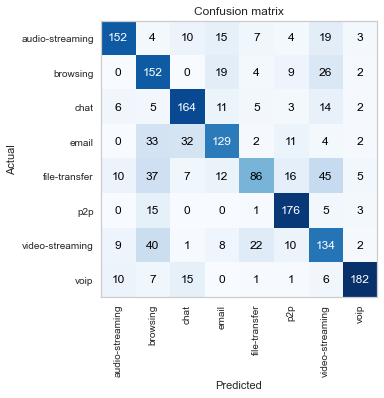

In [193]:
with learner.no_bar():
    learner.fit_one_cycle(epochs)
    results = learner.validate()
    interp = ClassificationInterpretation.from_learner(learner)
    interp.plot_confusion_matrix()

results

In [194]:
logger_1.df

,epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,f1_score,time
0,0,2.108653,2.062569,0.186006,0.184013,0.161446,00:01
1,1,1.962660,1.890246,0.345190,0.343549,0.313314,00:02
2,2,1.749419,1.674729,0.542274,0.546267,0.530625,00:02
3,3,1.494956,1.450321,0.570845,0.574897,0.562260,00:01
4,4,1.304180,1.285817,0.595918,0.599890,0.591957,00:01
5,5,1.183997,1.221067,0.623324,0.626696,0.623373,00:01
6,6,1.094678,1.138334,0.638484,0.642084,0.637930,00:01
7,7,1.045527,1.112976,0.636152,0.639345,0.632978,00:02
8,8,1.023357,1.097405,0.650146,0.653106,0.650272,00:01
9,9,1.004983,1.070905,0.664140,0.666703,0.664956,00:01


In [202]:
data.dls.encodes()

(#4) [(object,object) -> encodes
,(object,object) -> encodes
,(Tabular,object) -> encodes
(object,object) -> encodes
,(TensorImage,object) -> encodes
(Tabular,object) -> encodes
]

In [196]:
dir(data.dls)

['_DataLoader__idxs',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_add_tfms',
 '_call',
 '_component_attr_filter',
 '_component_attr_filter',
 '_component_attr_filter',
 '_dbunch_type',
 '_decode_batch',
 '_default',
 '_default',
 '_default',
 '_device',
 '_dir',
 '_dir',
 '_dir',
 '_dl_type',
 '_do_call',
 '_docs',
 '_docs',
 '_is_showable',
 '_methods',
 '_n_inp',
 '_new',
 '_noop_methods',
 '_one_pass',
 '_pre_show_batch',
 '_retain_dl',
 '_set',
 '_types',
 'add',
 'add_col',
 'add_na',
 'add_tfms',
 'after_batch',
 'after_item',
 'after_iter',
 'all_col_names',
 'all_cols',
 'axes',
 'before_batch',
 'before_it

In [ ]:
class RFF_Resnet_Model(nn.Module):
    def __init__(self, input_features=62, layers=[100 for _ in range(20)], output_features=8):
        super().__init__()
        self._layers = []
        _activations = [nn.ReLU(inplace=True) for _ in range(len(layers) - 1)] + [None]
    
        for i, layer in enumerate(layers):
            layers[i] = 2*(layer // 2)

        self.ff = rff.layers.GaussianEncoding(sigma=10.0, input_size=input_features, encoded_size=layers[0]//2).to('cpu')


        for i, x in enumerate(layers):
            if (i == 0):
                self._layers.append(BottleneckResidualBlock(
                    [   
                        self.ff,
                        # self.ff,
                        # rff.layers.GaussianEncoding(sigma=10.0, input_size=input_features, encoded_size=layers[i+1]//2),
                        LinBnDrop(2*(input_features//2), layers[i+1], act=_activations[i], lin_first=True)
                    ], i, 2*(input_features//2), layers[i+1]))
            elif (i == len(layers) - 1):
                self._layers.append(BottleneckResidualBlock(
                    [
                        LinBnDrop(x, output_features, act=_activations[i], lin_first=True)
                    ], 
                    i, x, output_features)
                )
                # self._layers.append(LinBnDrop(x, output_features, act=_activations[i], lin_first=True))
            else:
                self._layers.append(BottleneckResidualBlock(
                    [
                        # rff.layers.GaussianEncoding(sigma=10.0, input_size=x, encoded_size=layers[i+1]//2),
                        LinBnDrop(x, layers[i+1], act=_activations[i], lin_first=True)
                    ], 
                    i, x, layers[i+1]
                ))
        


        self.out = nn.Sequential(*self._layers)     
        
    def forward(self, x):
        return self.out(x)




In [127]:

# class ResNet_MLP(nn.Module):

class RFF_Res_MLP(Module):
    def __init__(self, input_features=62, output_features=8, config={'layers': [100 for _ in range(20)], 'cardinality':[1 for _ in range(20)], 'enc_sz': 20}):
        # super().__init__()

        cardinality  = config['cardinality']
        layers       = config['layers']
        enc_sz       = config['enc_sz']

        self.rff = rff.layers.GaussianEncoding(sigma=10.0, input_size=input_features, encoded_size=enc_sz).to('cpu')

        _layers = []
        _layers.append(Cat([self.rff, Identity()], dim=1))

        for i, x in enumerate(layers):
            if (i == 0):
                _layers.append(
                    BottleneckResidualBlock(
                        [   
                            BnReluLin(2*enc_sz + input_features, layers[i+1]) for _ in range(cardinality[i])
                        ], 
                        i,
                        2*enc_sz + input_features, 
                        layers[i+1]
                    )
                )
            elif (i == len(layers) - 1):
                # _layers.append(BottleneckResidualBlock(
                #     [
                #         BnReluLin(x, output_features)
                #     ], 
                #     i, x, output_features)
                # )

                _layers.append(BnReluLin(x, output_features))
                # _layers.append(LinBnDrop(x, output_features))
            else:
                _layers.append(
                    BottleneckResidualBlock(
                        [
                            BnReluLin(x, layers[i+1]) for _ in range(cardinality[i])
                        ], 
                        i, 
                        x, 
                        layers[i+1]
                    )
                )

        self.layers = nn.Sequential(*_layers)     
        
    def forward(self, x):
        return self.layers(x)




In [150]:
config = {'layers': layers, 'cardinality': cardinality, 'enc_sz': 30}


In [55]:
balanced_df.shape

(8576, 63)

In [151]:
learner = torch_learner(data.dls, metrics=[accuracy, F1Score(average='macro')], cbs=callbacks_1, config=config, model=RFF_Res_MLP)

(#3) [0.8736146092414856,0.711953341960907,0.7128546615549534]

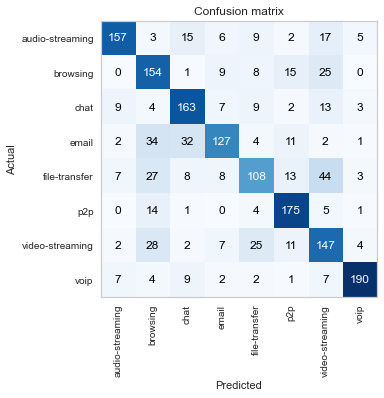

In [152]:
with learner.no_bar():
    learner.fit_one_cycle(epochs)
    results = learner.validate()
    interp = ClassificationInterpretation.from_learner(learner)
    interp.plot_confusion_matrix()

results

In [153]:
logger_1.df

,epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0,2.107791,2.137181,0.130029,0.119422,00:04
1,1,2.077492,2.121086,0.141691,0.133206,00:04
2,2,2.053169,2.022449,0.174344,0.171144,00:04
3,3,2.015842,2.038350,0.173178,0.163155,00:04
4,4,1.983400,1.970344,0.234402,0.228548,00:03
...,...,...,...,...,...,...
195,95,0.792558,0.897404,0.697959,0.700110,00:03
196,96,0.795710,0.879985,0.711370,0.712770,00:03
197,97,0.792507,0.891144,0.700875,0.702137,00:03
198,98,0.785194,0.888121,0.704373,0.705441,00:03


In [142]:
X_train = torch.FloatTensor(data.X_train.values)
X_test = torch.FloatTensor(data.X_test.values)
y_train = torch.LongTensor(data.y_train)
y_test = torch.LongTensor(data.y_test)

In [143]:
epochs    = 100
classes   = data.classes
model     = RFF_Res_MLP(input_features=62, output_features=len(classes))
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
model

RFF_Res_MLP(
  (rff): GaussianEncoding()
  (layers): Sequential(
    (0): Cat(
      (0): GaussianEncoding()
      (1): Identity()
    )
    (1): BottleneckResidualBlock(
      (linear): LinBnDrop(
        (0): Linear(in_features=102, out_features=100, bias=False)
        (1): ReLU(inplace=True)
        (2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): BottleneckResidualBlock(
      (linear): LinBnDrop(
        (0): Linear(in_features=100, out_features=100, bias=False)
        (1): ReLU(inplace=True)
        (2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (3): BottleneckResidualBlock(
      (linear): LinBnDrop(
        (0): Linear(in_features=100, out_features=100, bias=False)
        (1): ReLU(inplace=True)
        (2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (4): BottleneckResidualBlock(
      (linear): LinBnDrop

In [144]:
losses = []

for i in range(epochs):
    y_pred = model.forward(X_train)
    loss = criterion(y_pred, y_train)
    losses.append(loss)
    print(f'epoch: {i:2}  loss: {loss.item():10.8f}')
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


epoch:  0  loss: 2.12464285
epoch:  1  loss: 1.84177709
epoch:  2  loss: 1.69963527
epoch:  3  loss: 1.58846581
epoch:  4  loss: 1.48392034
epoch:  5  loss: 1.39162052
epoch:  6  loss: 1.31348169
epoch:  7  loss: 1.24795759
epoch:  8  loss: 1.19200587
epoch:  9  loss: 1.14272034
epoch: 10  loss: 1.09830463
epoch: 11  loss: 1.05823481
epoch: 12  loss: 1.02248275
epoch: 13  loss: 0.99044192
epoch: 14  loss: 0.96051556
epoch: 15  loss: 0.93262023
epoch: 16  loss: 0.90647709
epoch: 17  loss: 0.88170522
epoch: 18  loss: 0.85789627
epoch: 19  loss: 0.83471191
epoch: 20  loss: 0.81254500
epoch: 21  loss: 0.79079473
epoch: 22  loss: 0.76899880
epoch: 23  loss: 0.74828321
epoch: 24  loss: 0.72839707
epoch: 25  loss: 0.70868754
epoch: 26  loss: 0.68943626
epoch: 27  loss: 0.67068452
epoch: 28  loss: 0.65274066
epoch: 29  loss: 0.63552493
epoch: 30  loss: 0.61865777
epoch: 31  loss: 0.60281157
epoch: 32  loss: 0.58770746
epoch: 33  loss: 0.57298452
epoch: 34  loss: 0.55866468
epoch: 35  loss: 0.5

In [145]:

preds = []
with torch.no_grad():

    predictions = model.forward(X_test)
    preds = predictions.argmax(dim=1).numpy()




In [146]:
df_r = pd.DataFrame({'Y': y_test, 'YHat': preds})
df_r['Correct'] = [1 if corr == pred else 0 for corr, pred in zip(df_r['Y'], df_r['YHat'])]
df_r['label'] = df_r['Y'].apply(lambda x: classes[x])
df_r['prediction'] = df_r['YHat'].apply(lambda x: classes[x])

In [147]:
df_r['Correct'].sum() / len(df_r)

0.6932944606413994

<AxesSubplot:>

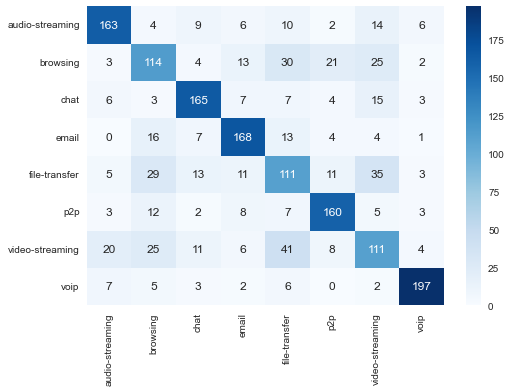

In [148]:
n_df = df_r.copy()
n_df = n_df.drop(['Y', 'YHat', 'Correct'], axis=1)

# n_df.pivot_table(index='label', columns='prediction', fill_value=0, aggfunc=np.sum)
cf = sklearn.metrics.confusion_matrix(df_r['label'], df_r['prediction'])
sns.heatmap(cf, annot=True, fmt='d', xticklabels=classes, yticklabels=classes, cmap='Blues')

In [ ]:
print(f'Last Execution: {datetime.datetime.now()}')
assert False, 'Nothing after this point is included in the study'